In [1]:
from General import functies as functies
from General import classes as classes
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join

In [2]:
#code geript van de geluidsproef
def X_tractor(inhoud, previous = None): #extraheert effectief nuttige data uit die txt-files


    #bepaal de initiële values van de fit (met de headerdata)
    amplitude = float(inhoud.split("PK-PK                :		")[1][:4])/2 #de helft van de peak-to-peak +20 om te kleine fits te breken

    gesplit = inhoud.split('Time interval        :		')

    #bepaal de stapbreedte
    getal = ""
    eenheid = ""
    count = 0
    punt_gevonden = False
    for digit in gesplit[1]:
        if digit.isdigit():
            getal += digit
        elif digit == '.' and not punt_gevonden:
            getal += digit
            punt_gevonden = True
        else:
            eenheid+=digit
            count+=1
        if count == 2:
            break
    getal = float(getal)
    #fix de SI prefix van de stapbreedte
    if eenheid == "us": #bro een u voor µ deze oscilloscoop is ass
        stapbreedte = getal *10**(-6)
    elif eenheid == "ms":
        stapbreedte = getal * 10**(-3)
    else:
        raise ChildProcessError("children have defined units of " + eenheid)
    #haal de twee kolommen uit de txt-file en transponeer ze
    tabel = gesplit[1].split('index		CH1_Voltage(mV)\n')[1]
    nuttigtransponent = [X.split('		') for X in tabel.split('\n')][:-1] #skip het laatste element want dat is leeg (een enter op het einde van de txt)
    nuttig = [[float(nuttigtransponent[j][i]) for j in range(len(nuttigtransponent))] for i in range(len(nuttigtransponent[0]))]
    #fix de verder gebruikte arrays in analyse
    T = np.array(nuttig[0])*stapbreedte
    T = T - T[0] #gezien het toch periodisch is kunnen we het laten starten bij nul
    Vpart = np.array(nuttig[1])        
    
    C = (np.max(Vpart)+np.min(Vpart))/2 #zou ook moeten werken i guess
    

    
    invals = [amplitude, C] #Was eerder 4*pi*freq, maar omega=2pif, dus idk wat het plan was
    #Eenheden zijn enorm cooked, 10^-5 factor moet nog bij freq om shit te doen kloppen, zie twee code blokken verder, hier wat getest (werkte op oude code)
    return T, Vpart, eenheid, invals

def uncook_data(Tpart, Vpart, V_part_fout):

    Tnew = []
    Vnew = []
    Verrnew = []
    indx = 0
    while indx < len(Tpart)-1:
        indx2 = indx
        while indx2 < len(Tpart)-1 and Tpart[indx] == Tpart[indx2]:
            indx2 += 1
        
        tijd = np.mean(np.array([Tpart[ind] for ind in range(indx, indx2)]))
        spanning = Vpart[indx]
        fout = np.sqrt(indx2 - indx)*V_part_fout[indx]
        Tnew.append(tijd)
        Vnew.append(spanning)
        Verrnew.append(fout)
        indx = indx2
    Tnew = np.array(Tnew)
    Vnew = np.array(Vnew)
    Verrnew = np.array(Verrnew)
    assert np.shape(Verrnew) == np.shape(Vnew)
    return Tnew, Vnew, Verrnew

#das Model des Elektrofelds
def model_E(Zeit, Festeparameters, Fitparameters):
    Kordelänge, model, x0 = Festeparameters
    phase, amplitude, Ruhe, omega, q = Fitparameters
    epsilon_nul = 8.85e-12

    if model == '1D quasistatic':
        epsilon_nul = 8.85e-12
        Abstand = x0 + amplitude * np.sin(omega*Zeit + phase)
        E = q/(4*np.pi*epsilon_nul) * (1/Abstand)**2 + Ruhe

    elif model == 'sinus':
        #voor de meme testen of een sinus werkt #spoiler: nee
        return amplitude * np.sin(omega*Zeit + phase) + x0
    
    elif model == '2D quasistatic':
        #quasistatisch, 2D-versie (met sin(x) = x-approc van de slinger)
        theta_max = np.arcsin(amplitude/Kordelänge)
        #print('theta_max in graden', theta_max*180/np.pi)
        theta = theta_max * np.sin(omega*Zeit + phase)
        AbstandKwadrat = (x0+Kordelänge*np.sin(theta))**2+Kordelänge**2*np.cos(theta)**2

        C = Ruhe #- np.average(q/(4*np.pi*epsilon_nul) * (1/np.linspace(0,1000,100000)**2)) #remove the average bias
        E = q/(4*np.pi*epsilon_nul) * (1/AbstandKwadrat)**(3/2) * (x0 + Kordelänge*np.sin(theta)) + C

    return E

def model_E_v2(t, proefparameters, fitparameters):
    epsilon_nul = 8085e-12 #nota bene: het is 8.85e-12, en dus moet er nog herschaald worden
    Koordlengte, model, x0 = proefparameters
    phase, amplitude_norm, C, omega, q_norm = fitparameters

    if model == "1D quasistatic":
        Afstand = 1 + amplitude_norm*np.sin(omega*t + phase)
        E = q_norm/(4*np.pi*epsilon_nul) * (1/Afstand)**2 + C
        return E
    elif model == "2D quasistatic":
        return model_E(t, proefparameters, fitparameters)

In [3]:
fitparamdict = dict()
def analyseer_data(pad, x0, Kordelänge, q, periodamount = None, method = '1D quasistatic', show_beginvoorwaarden = False, knipvanaf = 0, kniptot = 10, beginvoorwaarden = None, 
                   detailed_logs = False, bounds = None, constbounds = (None, None), v2 = True, minimizemethod = 'Nelder-Mead'):
    #de data-analyse voor de proef nummer 1
    global fitparamdict
    def model_proef(Zeit, params):
        if v2:
            return model_E_v2(Zeit, [Kordelänge, method, x0-0.11], params)
        else:
            return model_E(Zeit, [Kordelänge, method, x0-0.11], params)

    x_0_datapunt = classes.datapunt(x0-0.11, 0.002236, sp.symbols("x0")) #Actual afstand, met correcte fout, rekening gehouden met fout op plaatafstand
    g = 9.81
    omega = np.sqrt(g/Kordelänge)
    #extraheer data
    file = open(pad, 'rt')
    T, V, eenheid, invals = X_tractor(file.read()) #ACHTUNG: Spannung aus Millivolt
    V_err = np.full(np.shape(V), 20) #Ein Error von zwanzig Millivolt
    T, V, V_err = uncook_data(T, V, V_err)
    E = V/10 #E in V/m (want *100 voor V -> V/m en /1000 voor mV -> V)
    E_err = V_err/10
    file.close()
    if periodamount is not None:
        timestep = T[1] - T[0]
        aant_data = int(2*np.pi*periodamount/(omega*timestep))
        display(aant_data)
        T = T[:aant_data]
        E = E[:aant_data]
        E_err = E_err[:aant_data]
        knipvanaf = 0
        kniptot = aant_data*timestep
    elif knipvanaf != 0 or kniptot != 10: #knip vanaf een bepaalde timestamp
        n0 = int(knipvanaf/(T[1] - T[0]))
        if kniptot != 10:
            n1 = int(kniptot/(T[1] - T[0]))
        else:
            n1 = len(T)
        T = T[n0:n1]
        E = E[n0:n1]
        E_err = E_err[n0:n1]


    #beginvoorwaarden
    #die gemessen Parametern
    
    print(omega, 'omega_inval')
    #fast fourrier transform voor wat beginvoorwaarden
    frequentielijst = np.fft.fft(E)
    modulus = np.abs(frequentielijst)
    C_0 = np.real(frequentielijst[0])*(T[1] - T[0]) # tes kaduk eh
    print('C_0 by fft', C_0)
    eigenfreq = np.argmax(modulus[1:]) #ça ne marche pas donc on ne l'utilise pas; il faut que ça soit 50Hz, parce que la prise existe, donc jsp mais il faut multiplier par 10
    print(eigenfreq)
    C_0 = -300 #hehehe spuug en arbitraire constantes go brrrr

    if bounds is None:
        bounds = [(-2*np.pi, 2*np.pi), (0,2), constbounds, (omega*3/4, omega*5/4), (1e-10, 1e-2)]
    if beginvoorwaarden is None:
        beginvoorwaarden = [-1.3, .15/x_0_datapunt.get_val(), C_0, omega, q/(x_0_datapunt.get_val()**2)]
    else:
        beginvoorwaarden[1] /= x_0_datapunt.get_val()
        beginvoorwaarden[4] /= x_0_datapunt.get_val()**2
    print(beginvoorwaarden)
    def beginvwd(x,y):
        #1D, m1-1: 
        C_0 = -300
        return beginvoorwaarden
        #2D, m1-1: #fix
        #return [0, .3, C_0, omega, q, 0.35]



    #fit het boeltje
    print('beginvwd: ', beginvwd(0,0))
    print('bounds: ', bounds)
    outp = functies.fit(['phi', 'A_norm', 'C_0', 'omega', 'q_norm'], model_proef, beginvwd, T, E, E_err, 
                        detailed_logs=detailed_logs, bounds = bounds,
                        minimizemethod = minimizemethod, fuck_mijn_pc=False, fuck_CPU = False)
    #, bounds = [(-np.pi, np.pi), (0,0.5), (C_0-10, C_0+10), (omega*3/4, omega*5/4), (1e-10, 1e-8), (0.1, 0.4)] gebruik ze of niet
    print(outp)
    fitparams = [param.get_val() for param in outp]
    act_outp = outp.copy()
    act_outp[1], act_outp[4] = outp[1]*x_0_datapunt, outp[4]*x_0_datapunt*x_0_datapunt
    act_params = [act.get_val() for act in act_outp]



    print("######################### Real data incoming ##############################")
    #Output correct weergeven (moet helaas hardcoded)
    for i in range(len(fitparams)):
        if i == 1:
            amp_actual = outp[i]*x_0_datapunt
            outp[i] = amp_actual
            print(amp_actual)
        elif i == 4:
            q_actual = outp[i]*x_0_datapunt*x_0_datapunt * 8.85*(1/8085) #geen zin om pow te implementeren ok #de schalingsfactor is om de foute waarde van epsilon_nul te corrigeren
            outp[i] = q_actual
            print(q_actual)
        else:
            print(outp[i])




    ##het boeltje plotten
    fig, ax = plt.subplots(1,1, figsize = (30,10))
    ax.errorbar(T, E, yerr = E_err, label = 'data', fmt = '')
    Zeitlinspace = np.linspace(knipvanaf,kniptot,1000)
    ax.plot(Zeitlinspace, model_proef(Zeitlinspace, fitparams), label = 'fit')
    if show_beginvoorwaarden:
        ax.plot(Zeitlinspace, model_proef(Zeitlinspace, beginvwd(0,0)), label = 'beginvoorwaarden')
    ax.set_ylabel('$E_x$ [V/m]')
    ax.set_xlabel('t [s]')
    #ax.set_xlim(0,4) #esthetische parameter
    ax.legend()
    plt.tight_layout()
    plt.show()
    

    #toevoegen aan de dictionary met fitparameters
    naam = pad[12:16]
    fitparamdict[naam] = outp.copy()

4074

3.8553386833890952 omega_inval
C_0 by fft -624.234375
4070
[0, 0.1521739130434783, -490, 3.8, 1.181474480151229e-08]
beginvwd:  [0, 0.1521739130434783, -490, 3.8, 1.181474480151229e-08]
bounds:  [(-6.283185307179586, 6.283185307179586), (0, 2), (None, None), (2.891504012541821, 4.819173354236369), (1e-10, 0.01)]
[[-1.0590430853152093, -1.061215195652467], [0.23795610056732897, 0.23818036952400015], [-521.8217556088836, -522.2626761480091], [3.810342418651171, 7.456562635671841], [3.5243349642728095e-05, 3.526032812619218e-05]]
phi heeft als waarde: -1.0592 + -0.0020178 - -0.00015429 met 68% betrouwbaarheidsinterval: [-1.059, -1.0612] 
A_norm heeft als waarde: 0.23808 + 9.5796e-05 - 0.00012847 met 68% betrouwbaarheidsinterval: [0.23796, 0.23818] 
C_0 heeft als waarde: -522.25 + -0.013462 - -0.42746 met 68% betrouwbaarheidsinterval: [-521.82, -522.26] 
omega heeft als waarde: 3.8103 + 3.6463 - -9.037e-05 met 68% betrouwbaarheidsinterval: [3.8103, 7.4566] 
q_norm heeft als waarde: 3.5247e

c:\Users\User\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


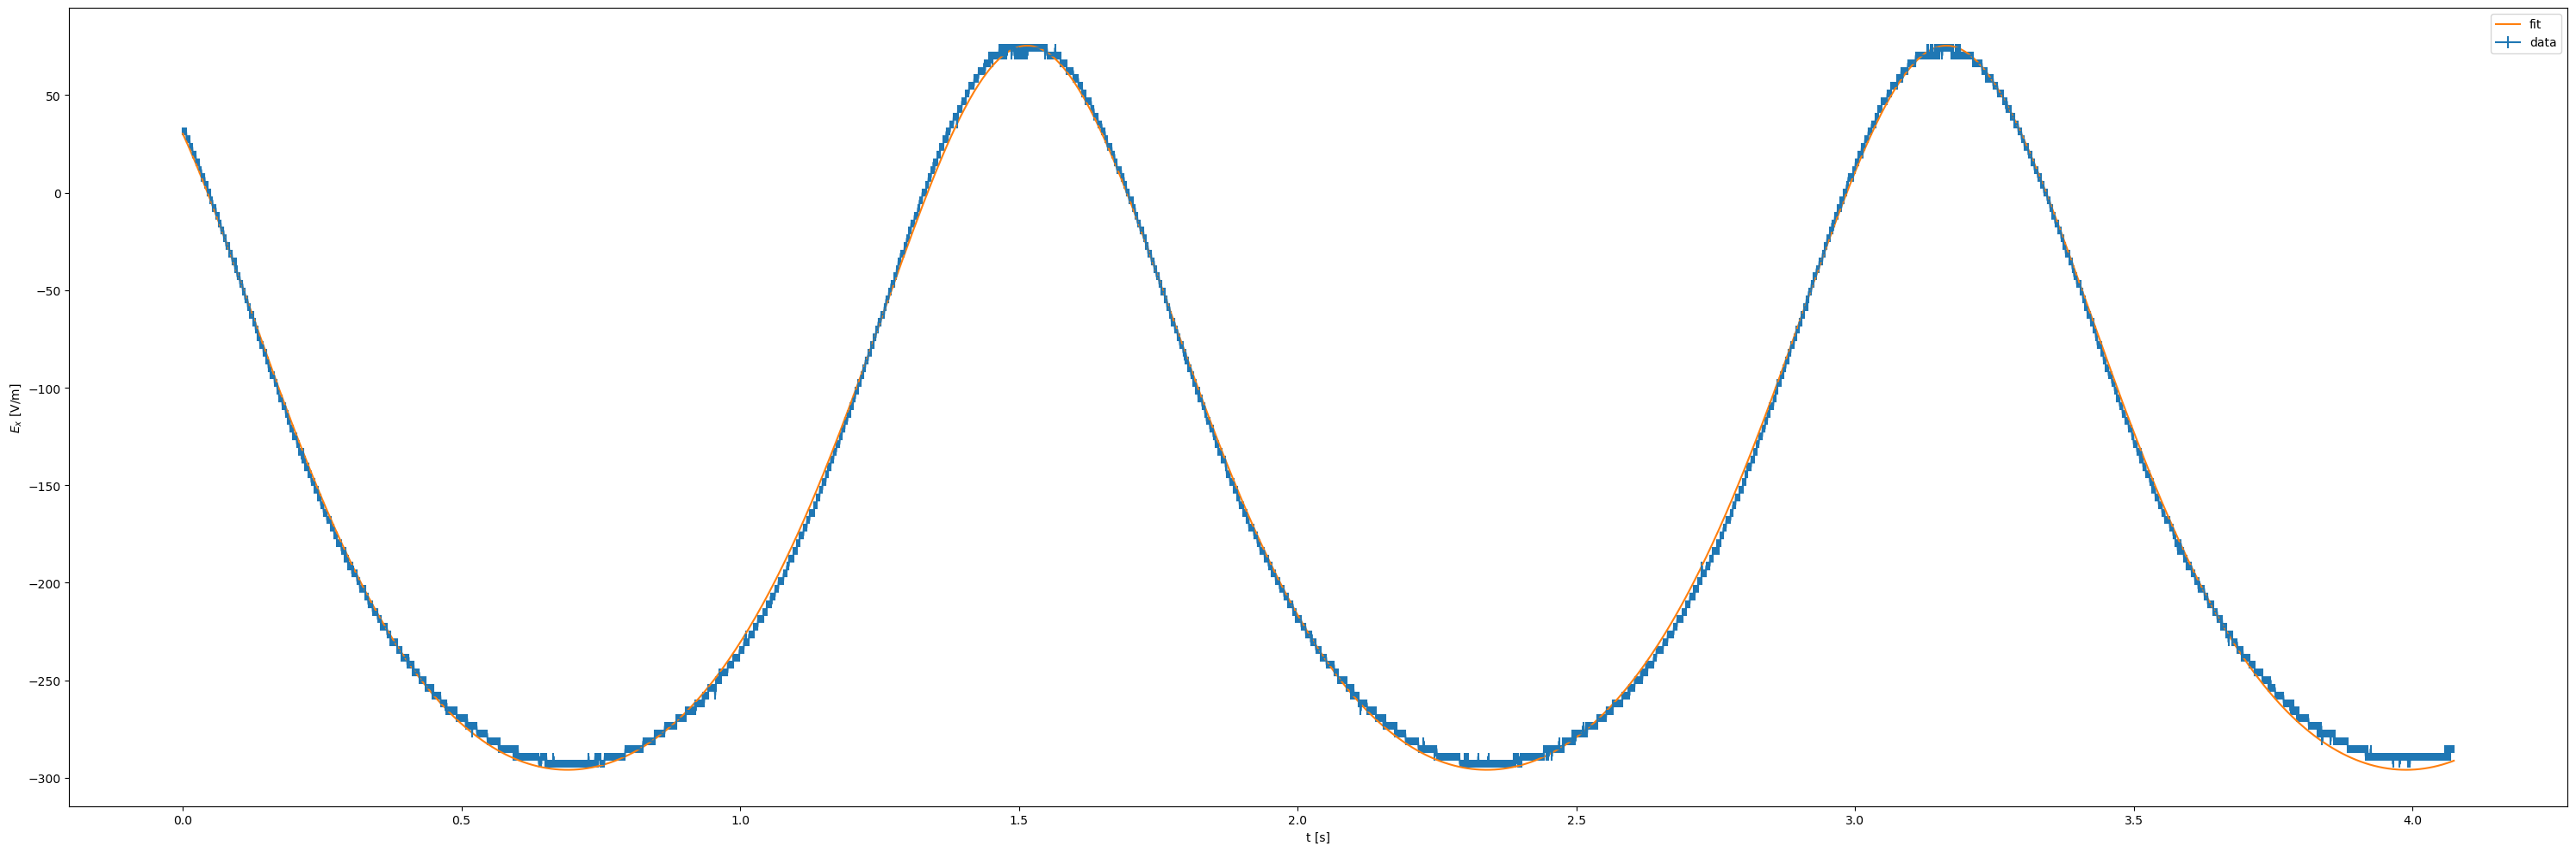

4074

3.8553386833890952 omega_inval
C_0 by fft -815.26171875
1
[1, 0.1521739130434783, -490, 3.8, 2.362948960302458e-08]
beginvwd:  [1, 0.1521739130434783, -490, 3.8, 2.362948960302458e-08]
bounds:  [(-6.283185307179586, 6.283185307179586), (0, 2), (None, None), (2.891504012541821, 4.819173354236369), (1e-10, 0.01)]
[[-0.05452615404758308, -0.057189496245398284], [-0.2068354410569877, -0.20740289359287076], [-489.17402176201887, -489.3398924310831], [3.819103522218712, 5.632478228137726], [2.61288900352855e-05, 2.6150914211834692e-05]]
phi heeft als waarde: -0.056873 + -0.00031638 - -0.002347 met 68% betrouwbaarheidsinterval: [-0.054526, -0.057189] 
A_norm heeft als waarde: -0.20687 + -0.00052937 - -3.8081e-05 met 68% betrouwbaarheidsinterval: [-0.20684, -0.2074] 
C_0 heeft als waarde: -489.29 + -0.04941 - -0.11646 met 68% betrouwbaarheidsinterval: [-489.17, -489.34] 
omega heeft als waarde: 3.8182 + 1.8143 - -0.00091181 met 68% betrouwbaarheidsinterval: [3.8191, 5.6325] 
q_norm heeft als w

c:\Users\User\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:580: RuntimeWarning: Method BFGS cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
c:\Users\User\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


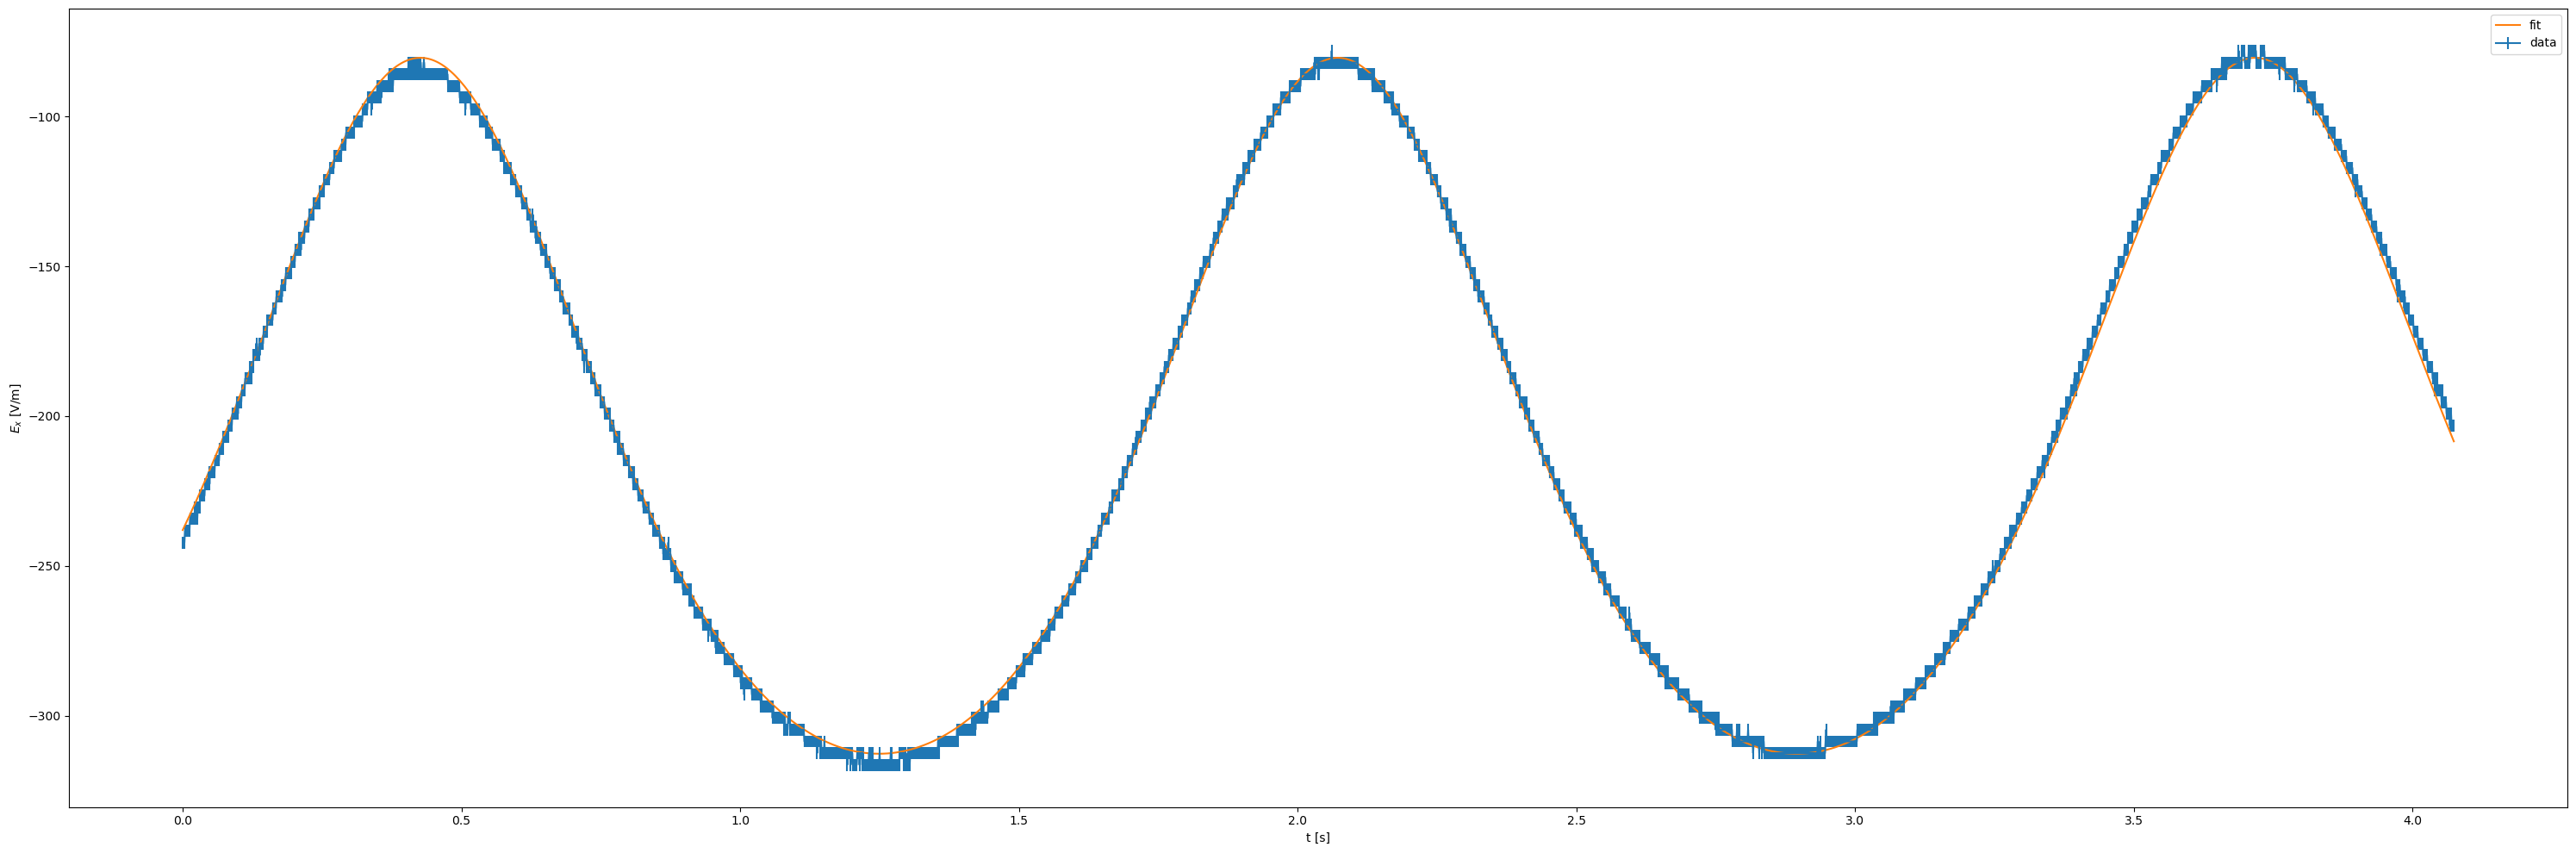

4074

3.8553386833890952 omega_inval
C_0 by fft -534.5859375
1
[-1.3, 0.32608695652173914, -300, 3.8553386833890952, 2.362948960302458e-08]
beginvwd:  [-1.3, 0.32608695652173914, -300, 3.8553386833890952, 2.362948960302458e-08]
bounds:  [(-6.283185307179586, 6.283185307179586), (0, 2), (None, None), (2.891504012541821, 4.819173354236369), (1e-10, 0.01)]
[[-3.1916573526757874, -3.1970994780107715], [0.11689193440799153, 0.11715075342288811], [-603.4754761235077, -604.1542435080339], [3.8154319420880096, 5.6350168540589785], [4.5594516043556144e-05, 4.5666018428323205e-05]]
phi heeft als waarde: -3.1918 + -0.0052687 - -0.00017341 met 68% betrouwbaarheidsinterval: [-3.1917, -3.1971] 
A_norm heeft als waarde: 0.1171 + 4.9775e-05 - 0.00020904 met 68% betrouwbaarheidsinterval: [0.11689, 0.11715] 
C_0 heeft als waarde: -603.48 + -0.67018 - -0.0085863 met 68% betrouwbaarheidsinterval: [-603.48, -604.15] 
omega heeft als waarde: 3.8156 + 1.8194 - 0.00020739 met 68% betrouwbaarheidsinterval: [3.8154, 

c:\Users\User\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:580: RuntimeWarning: Method BFGS cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
c:\Users\User\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


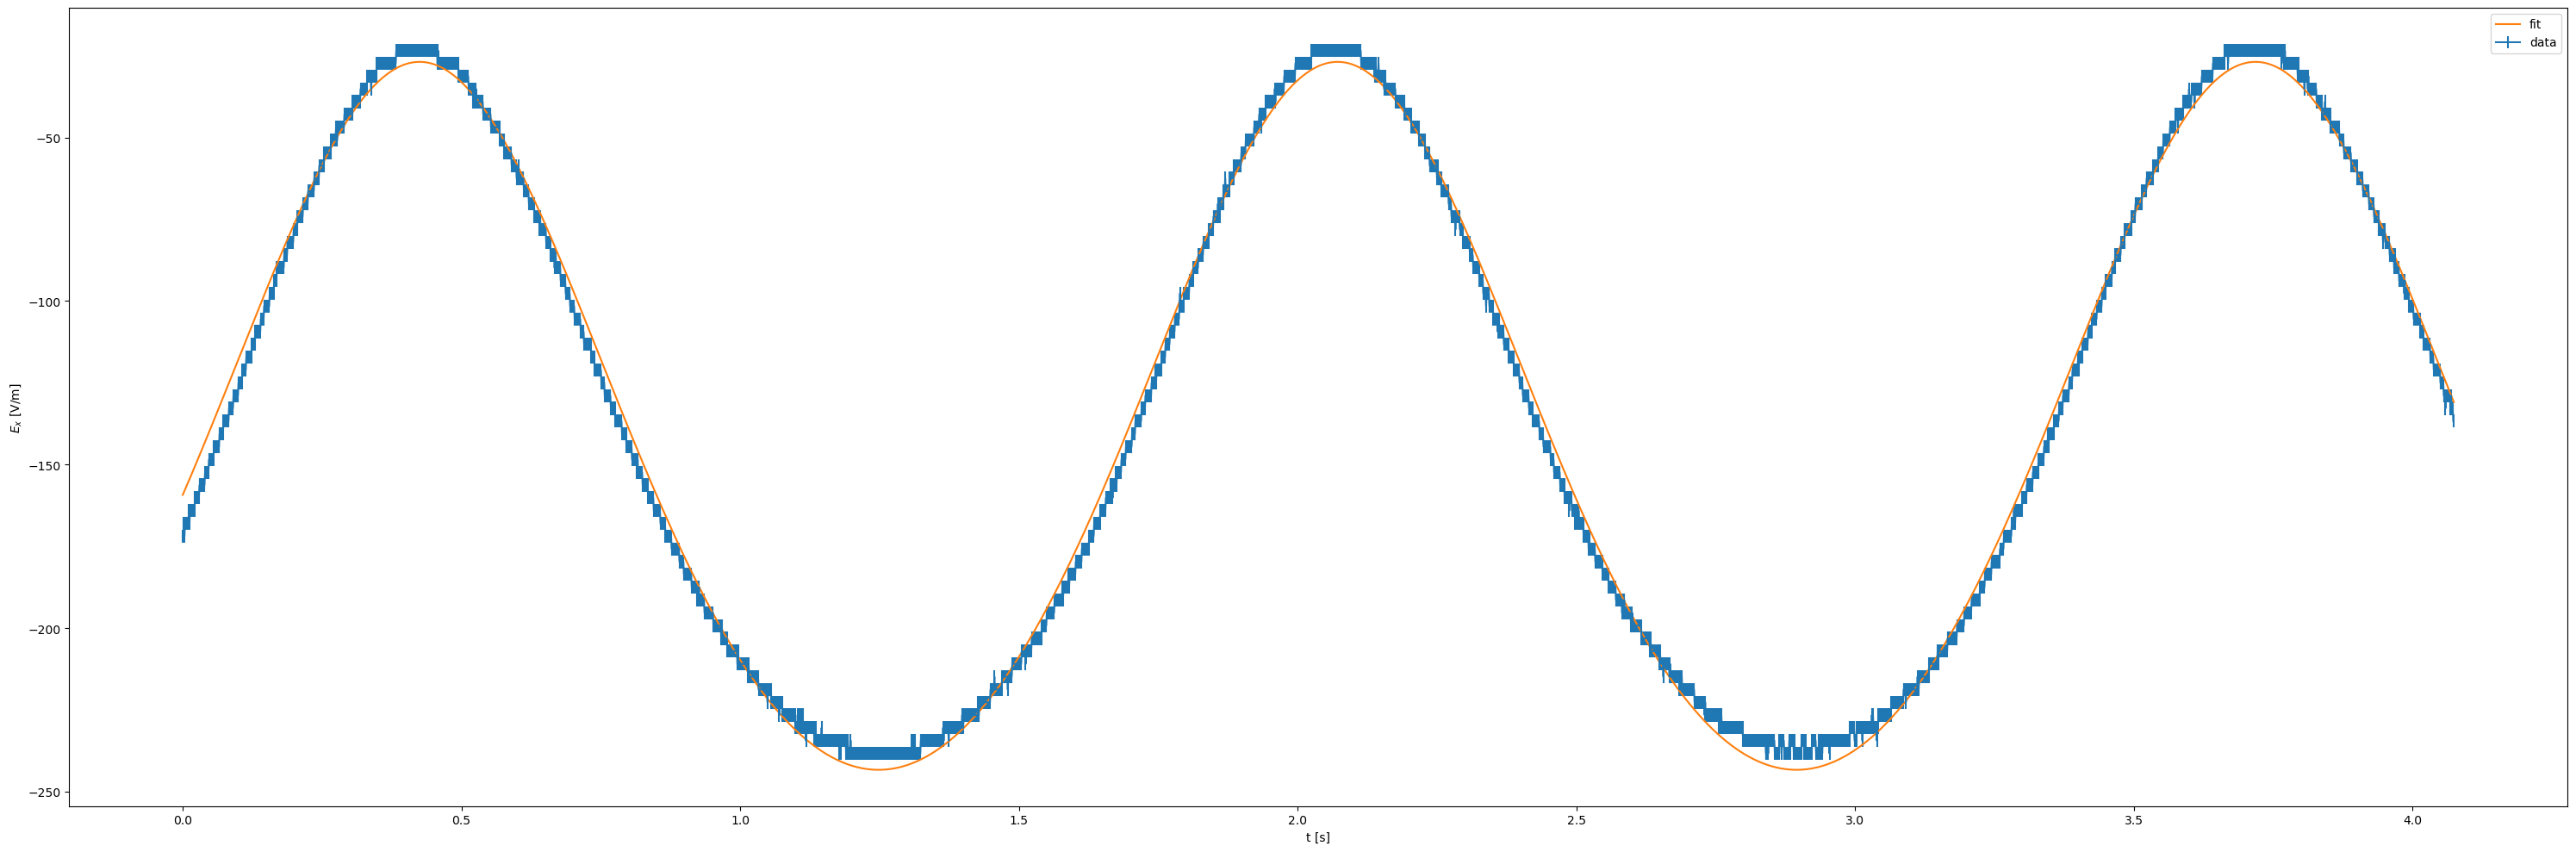

In [4]:
#de data gerecoverd vanuit een louche Githubkelder
# parameters beginvoorwaarden: 'phi', 'A', 'C_0', 'omega', 'q'
#proef 1: OK
analyseer_data('Vrije proef/m1-1.txt', 0.57, 0.66, 5e-9, periodamount=2.5,  beginvoorwaarden = [0, 0.07, -490, 3.8, 2.5e-9], detailed_logs=False, minimizemethod = 'TNC')
analyseer_data('Vrije proef/m1-2.txt', 0.57, 0.66, 5e-9, beginvoorwaarden = [1, 0.07, -490, 3.8, 5e-9], periodamount=2.5, detailed_logs=False, minimizemethod='BFGS')
analyseer_data('Vrije proef/m1-3.txt', 0.57, 0.66, 5e-9, detailed_logs=False, periodamount=2.5, minimizemethod='BFGS')

3.8553386833890952 omega_inval
C_0 by fft 268.39843749997044
4
[-1.3, 0.32608695652173914, -300, 3.8553386833890952, 1.4177693761814749e-08]
beginvwd:  [-1.3, 0.32608695652173914, -300, 3.8553386833890952, 1.4177693761814749e-08]
bounds:  [(-6.283185307179586, 6.283185307179586), (0, 2), (None, None), (2.891504012541821, 4.819173354236369), (1e-10, 0.01)]
[[0.06637845579786192, 0.06823763149983378], [0.2814384132504784, 0.2825528985791171], [-203.5800759944044, -203.96773315975017], [0.4021891148542823, 7.84972499997372], [2.117905799841704e-05, 2.1188767260777896e-05]]
phi heeft als waarde: 0.068087 + 0.00015088 - 0.0017083 met 68% betrouwbaarheidsinterval: [0.066378, 0.068238] 
A_norm heeft als waarde: 0.28145 + 0.0011043 - 1.0148e-05 met 68% betrouwbaarheidsinterval: [0.28144, 0.28255] 
C_0 heeft als waarde: -203.59 + -0.38041 - -0.0072511 met 68% betrouwbaarheidsinterval: [-203.58, -203.97] 
omega heeft als waarde: 3.8085 + 4.0412 - 3.4063 met 68% betrouwbaarheidsinterval: [0.40219

c:\Users\User\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:580: RuntimeWarning: Method BFGS cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
c:\Users\User\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
c:\Users\User\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


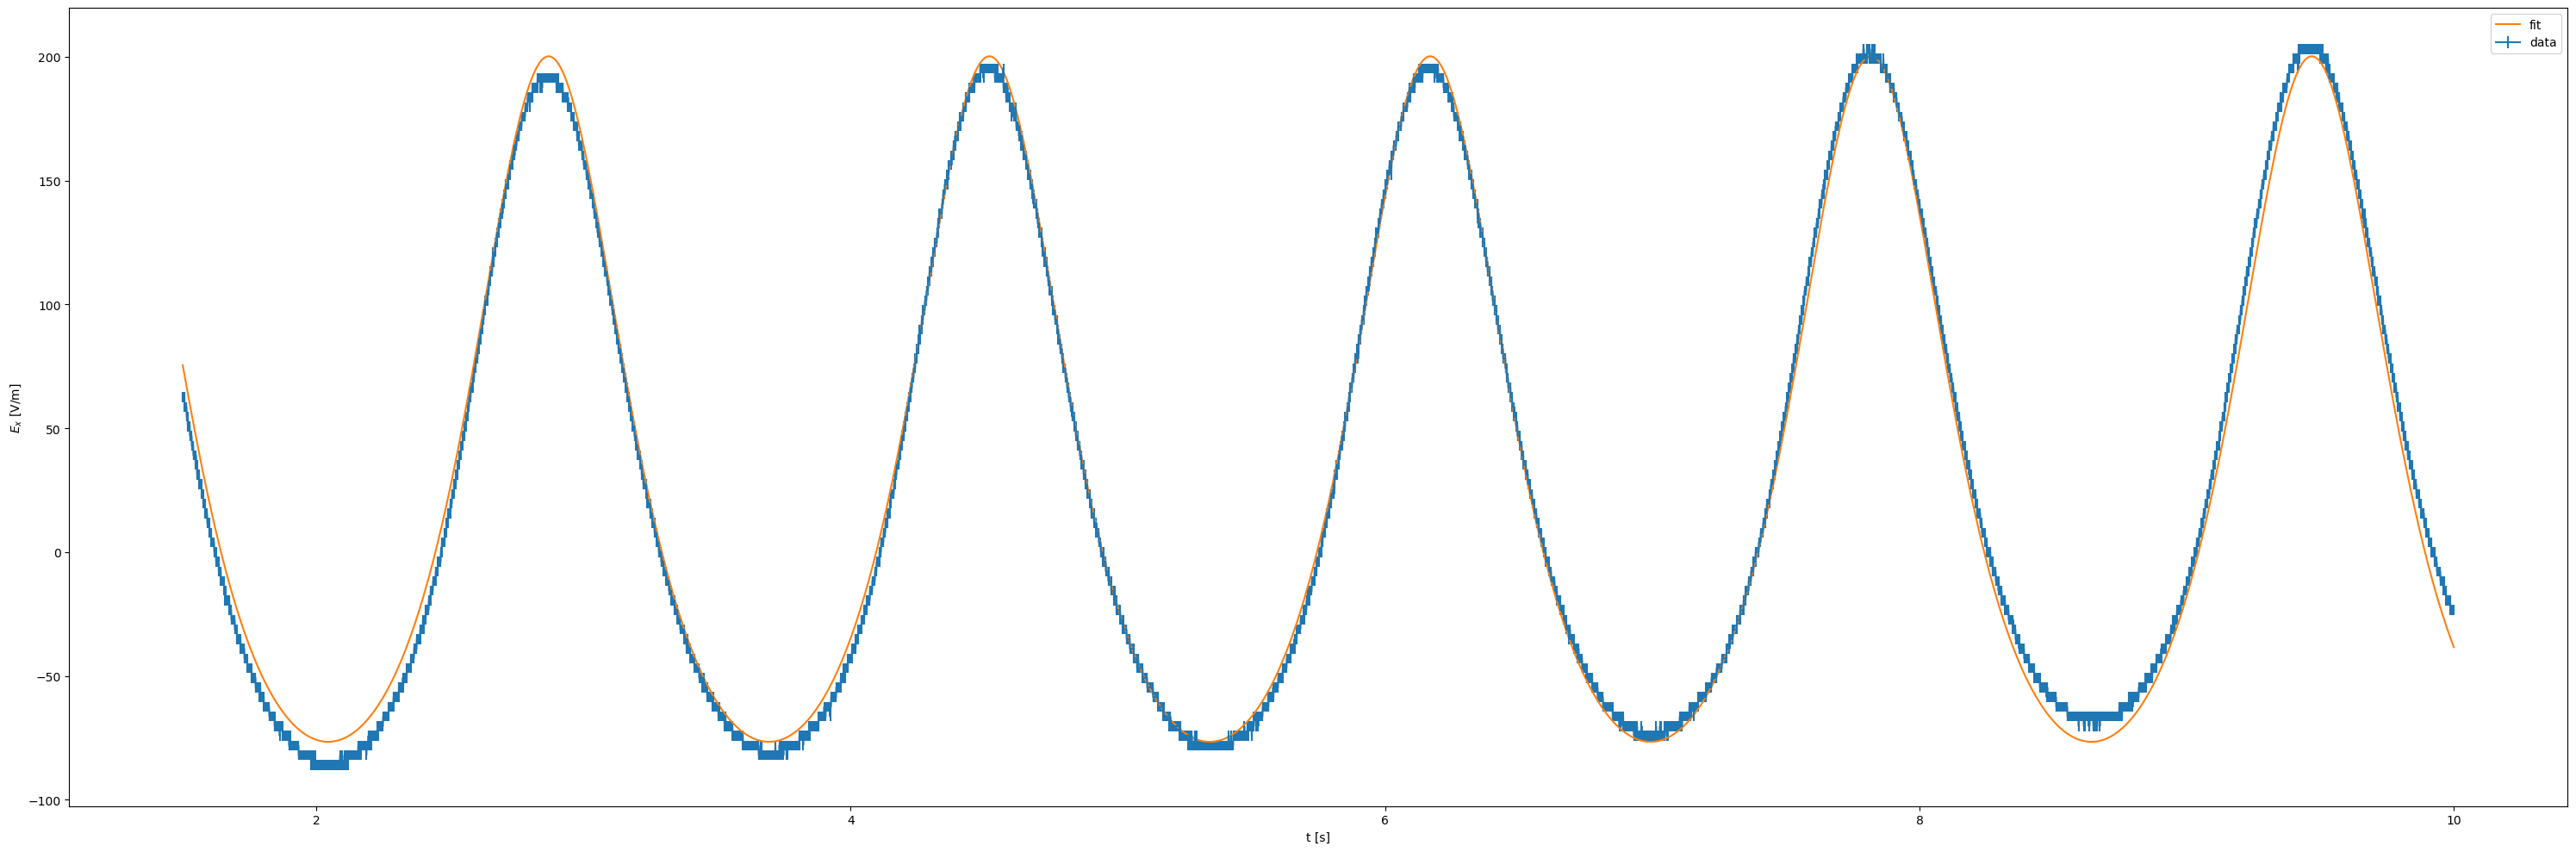

3.8553386833890952 omega_inval
C_0 by fft 652.097656249928
4
[0, 0.06521739130434782, -400, 3.8, 2.1266540642722122e-08]
beginvwd:  [0, 0.06521739130434782, -400, 3.8, 2.1266540642722122e-08]
bounds:  [(-6.283185307179586, 6.283185307179586), (0, 2), (None, None), (2.891504012541821, 4.819173354236369), (1e-10, 0.01)]
[[0.9990792348134878, 1.0002006224491975], [0.2973672757245036, 0.2989452077019202], [-188.29336756587608, -188.51588702662735], [0.9235283985101389, 7.1204083995737095], [2.3737063154303273e-05, 2.3787129361461658e-05]]
phi heeft als waarde: 1 + 0.00019518 - 0.00092621 met 68% betrouwbaarheidsinterval: [0.99908, 1.0002] 
A_norm heeft als waarde: 0.29737 + 0.0015728 - 5.0859e-06 met 68% betrouwbaarheidsinterval: [0.29737, 0.29895] 
C_0 heeft als waarde: -188.5 + -0.013176 - -0.20934 met 68% betrouwbaarheidsinterval: [-188.29, -188.52] 
omega heeft als waarde: 3.8091 + 3.3113 - 2.8856 met 68% betrouwbaarheidsinterval: [0.92353, 7.1204] 
q_norm heeft als waarde: 2.3737e-05 

c:\Users\User\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:580: RuntimeWarning: Method BFGS cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
c:\Users\User\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


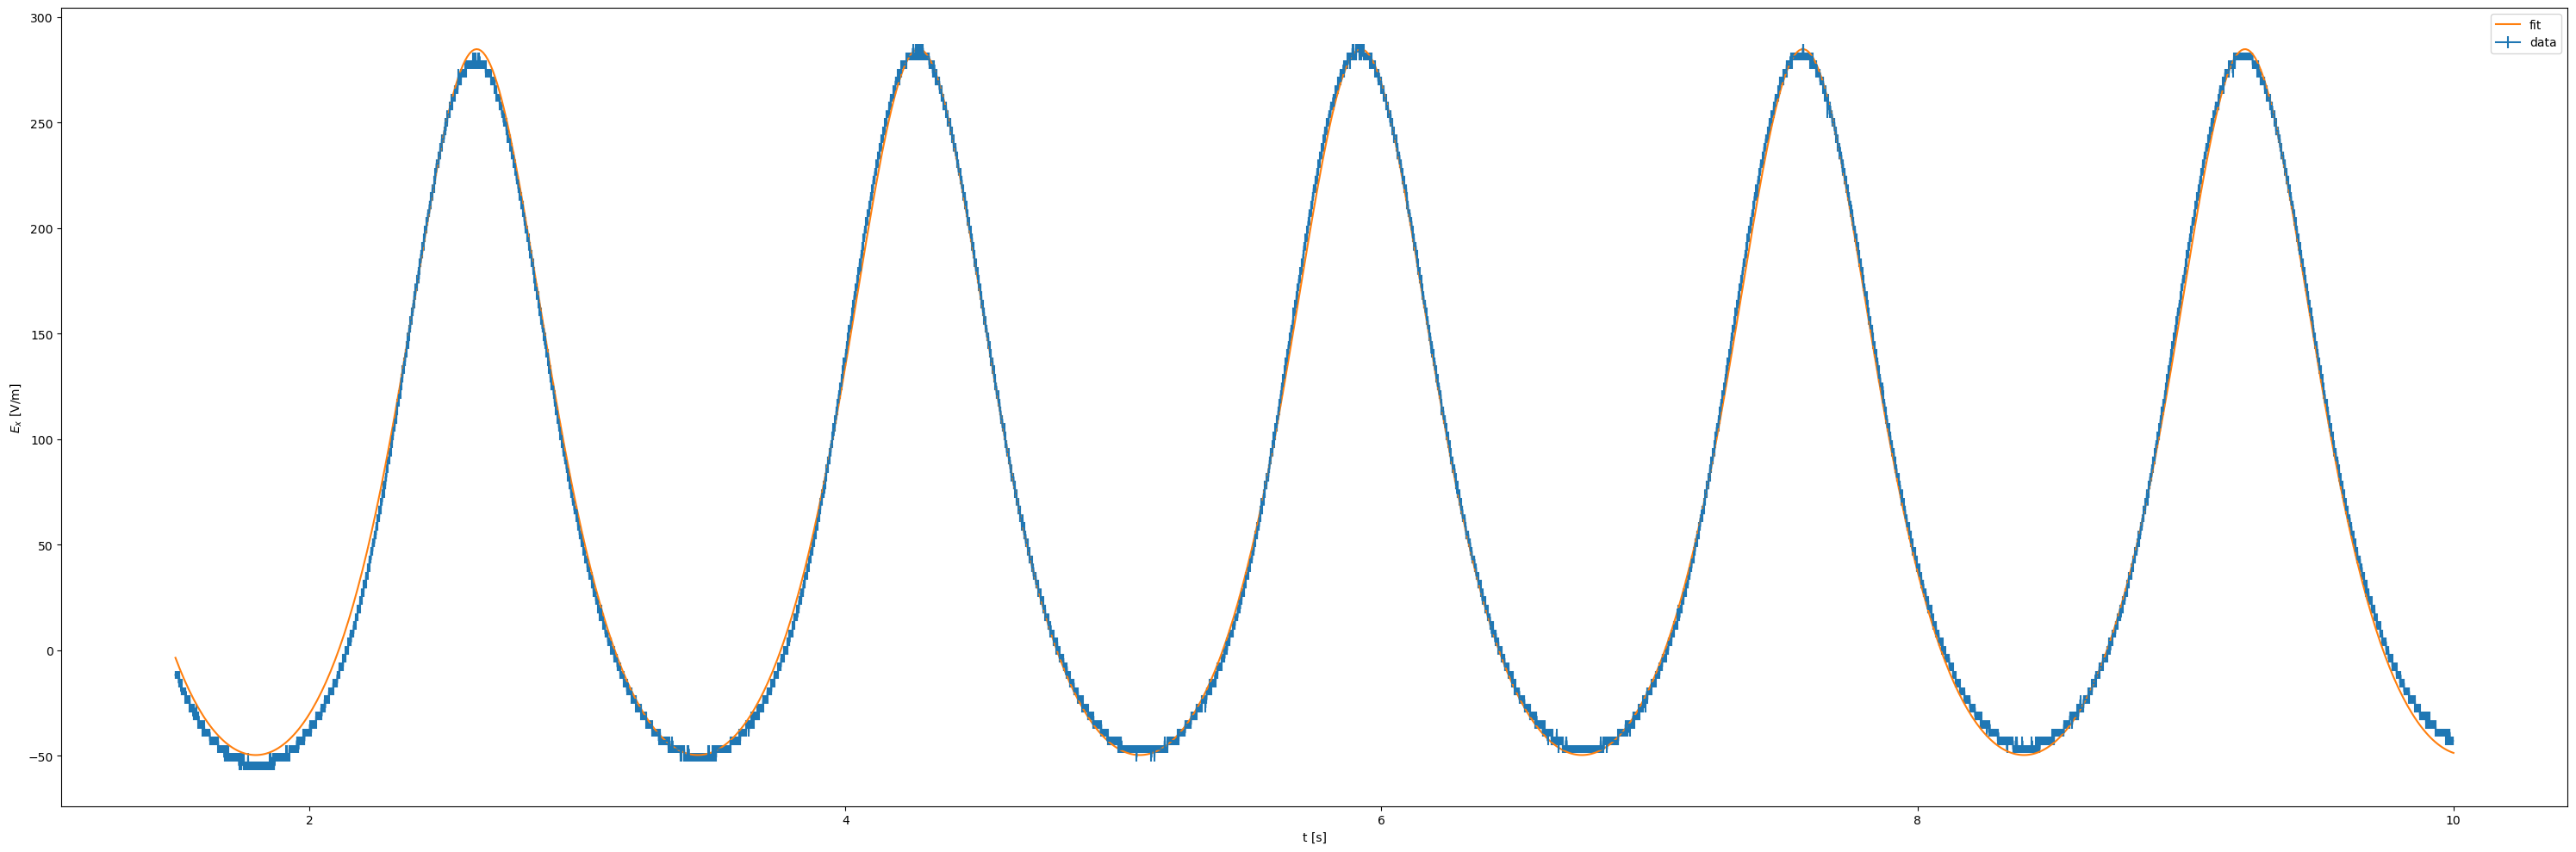

3.8553386833890952 omega_inval
C_0 by fft 209.58203125
9992
[-1.570795, 0.32608695652173914, -200, 4, 4.725897920604916e-09]
beginvwd:  [-1.570795, 0.32608695652173914, -200, 4, 4.725897920604916e-09]
bounds:  [(-6.283185307179586, 6.283185307179586), (0, 2), (None, None), (2.891504012541821, 4.819173354236369), (1e-10, 0.01)]
[[-2.384906194342654, -2.387628149704667], [0.11511671640611944, 0.11543418824155871], [-195.7265843724465, -195.8275926595942], [-3.57708171158107, 3.8168143720186585], [2.1527205206199776e-05, 2.153704544096777e-05]]
phi heeft als waarde: -2.3864 + -0.0012171 - -0.0015049 met 68% betrouwbaarheidsinterval: [-2.3849, -2.3876] 
A_norm heeft als waarde: 0.11534 + 9.4235e-05 - 0.00022324 met 68% betrouwbaarheidsinterval: [0.11512, 0.11543] 
C_0 heeft als waarde: -195.79 + -0.036148 - -0.064861 met 68% betrouwbaarheidsinterval: [-195.73, -195.83] 
omega heeft als waarde: 3.8165 + 0.00028457 - 7.3936 met 68% betrouwbaarheidsinterval: [-3.5771, 3.8168] 
q_norm heeft al

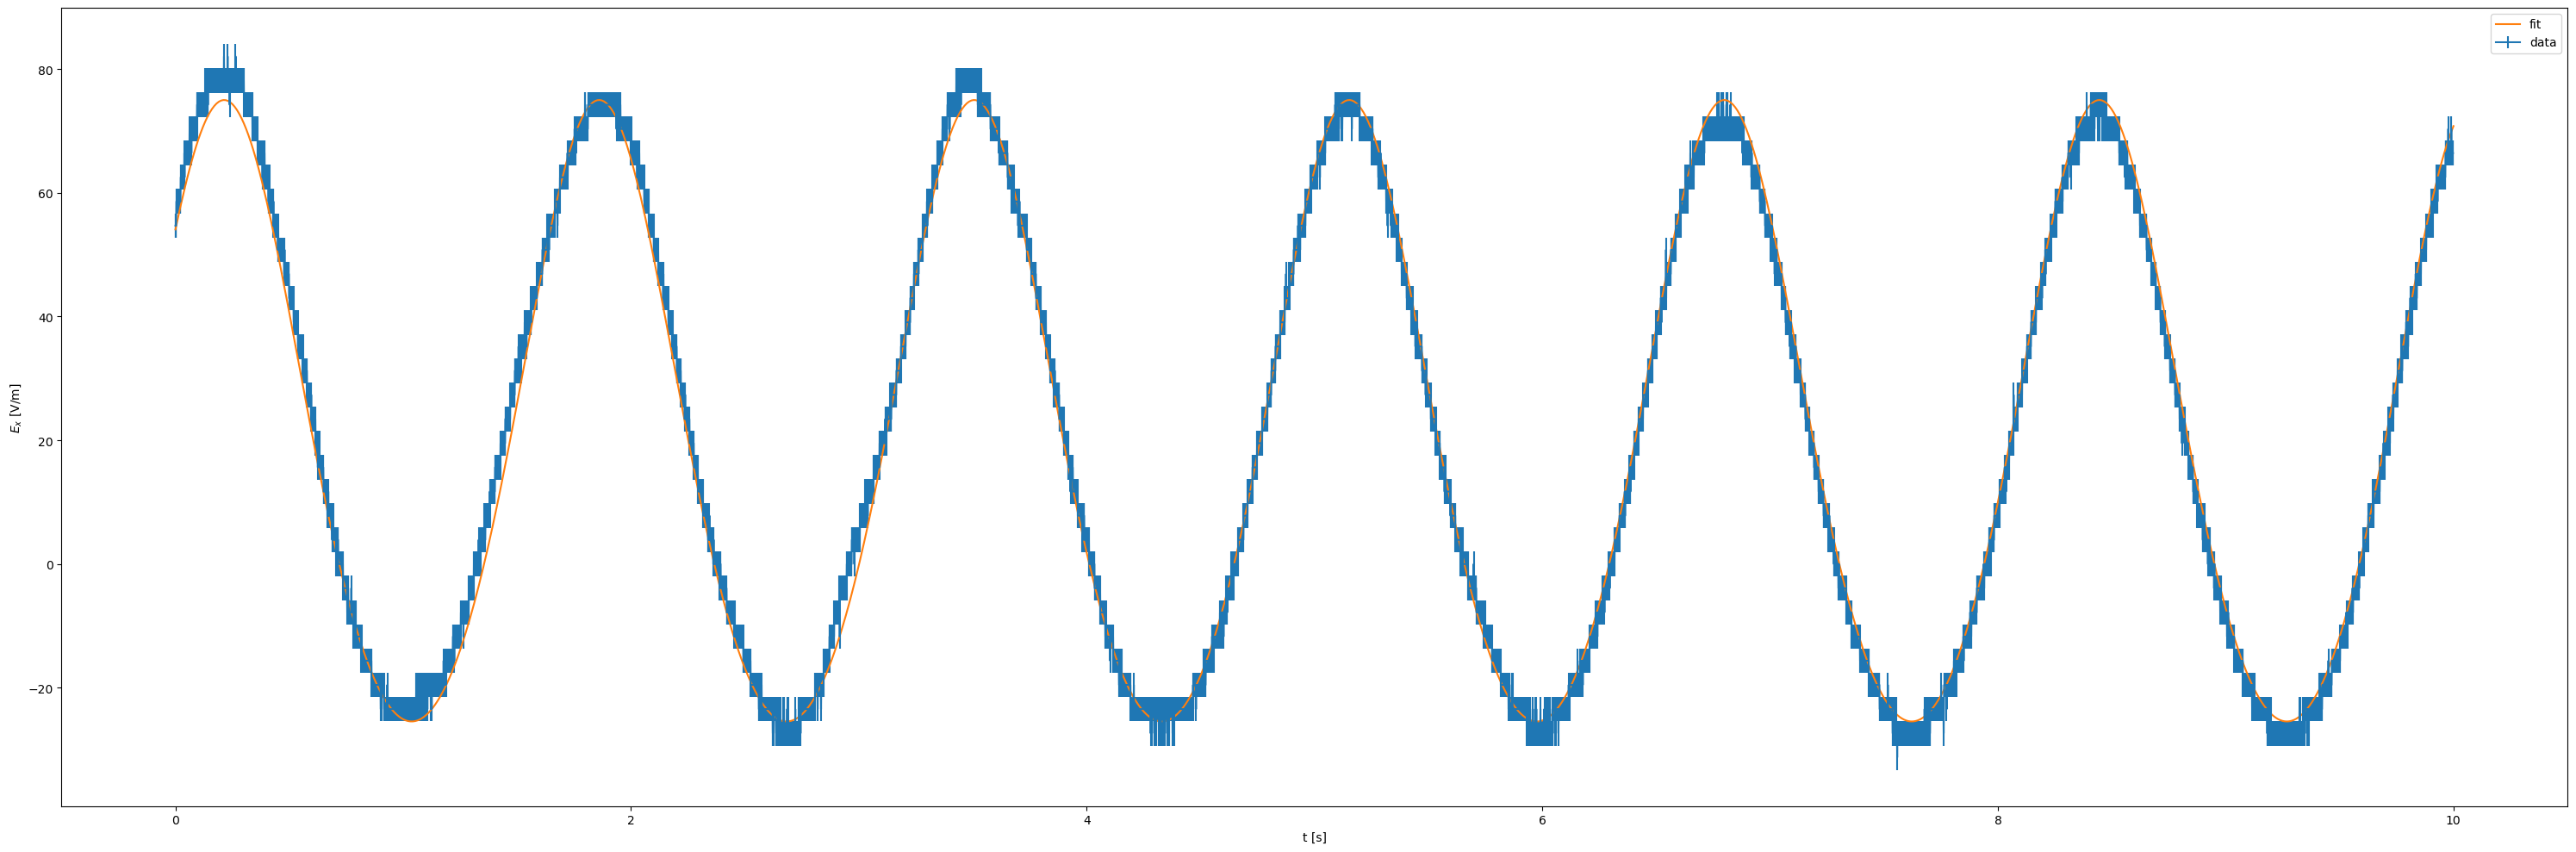

In [5]:
# parameters beginvoorwaarden: 'phi', 'A', 'C_0', 'omega', 'q', 'x0'"
#proef 2: OK
analyseer_data('Vrije proef/m2-1.txt', 0.57, 0.66, 3e-9, knipvanaf = 1.5, detailed_logs=False, minimizemethod='BFGS') #amplitude doet raar
analyseer_data('Vrije proef/m2-2.txt', 0.57, 0.66, 3e-9, knipvanaf = 1.5, beginvoorwaarden = [0, 0.03, -400, 3.8, 4.5e-9], detailed_logs=False, minimizemethod='BFGS')
analyseer_data('Vrije proef/m2-3.txt', 0.57, 0.66, 3e-9, beginvoorwaarden = [-3.14159/2, .15, -200, 4, 1e-9], detailed_logs=False, minimizemethod='TNC')

3.8553386833890952 omega_inval
C_0 by fft -1273.2421875
9992
[0.1, 0.32608695652173914, -490, 4.028, 4.725897920604916e-09]
beginvwd:  [0.1, 0.32608695652173914, -490, 4.028, 4.725897920604916e-09]
bounds:  [(-6.283185307179586, 6.283185307179586), (0, 2), (None, None), (2.891504012541821, 4.819173354236369), (1e-10, 0.01)]
[[1.7940494653105954, 1.8584351951478666], [0.058606419392900455, 0.060794328500784624], [-484.189342742886, -484.4218495252826], [-0.5595327528423134, 5.8764933415636715], [3.614092014545927e-05, 3.615409738789043e-05]]
phi heeft als waarde: 1.7941 + 0.064347 - 3.8852e-05 met 68% betrouwbaarheidsinterval: [1.794, 1.8584] 
A_norm heeft als waarde: 0.06079 + 4.0616e-06 - 0.0021838 met 68% betrouwbaarheidsinterval: [0.058606, 0.060794] 
C_0 heeft als waarde: -484.41 + -0.010564 - -0.22194 met 68% betrouwbaarheidsinterval: [-484.19, -484.42] 
omega heeft als waarde: 3.8597 + 2.0168 - 4.4192 met 68% betrouwbaarheidsinterval: [-0.55953, 5.8765] 
q_norm heeft als waarde: 

c:\Users\User\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


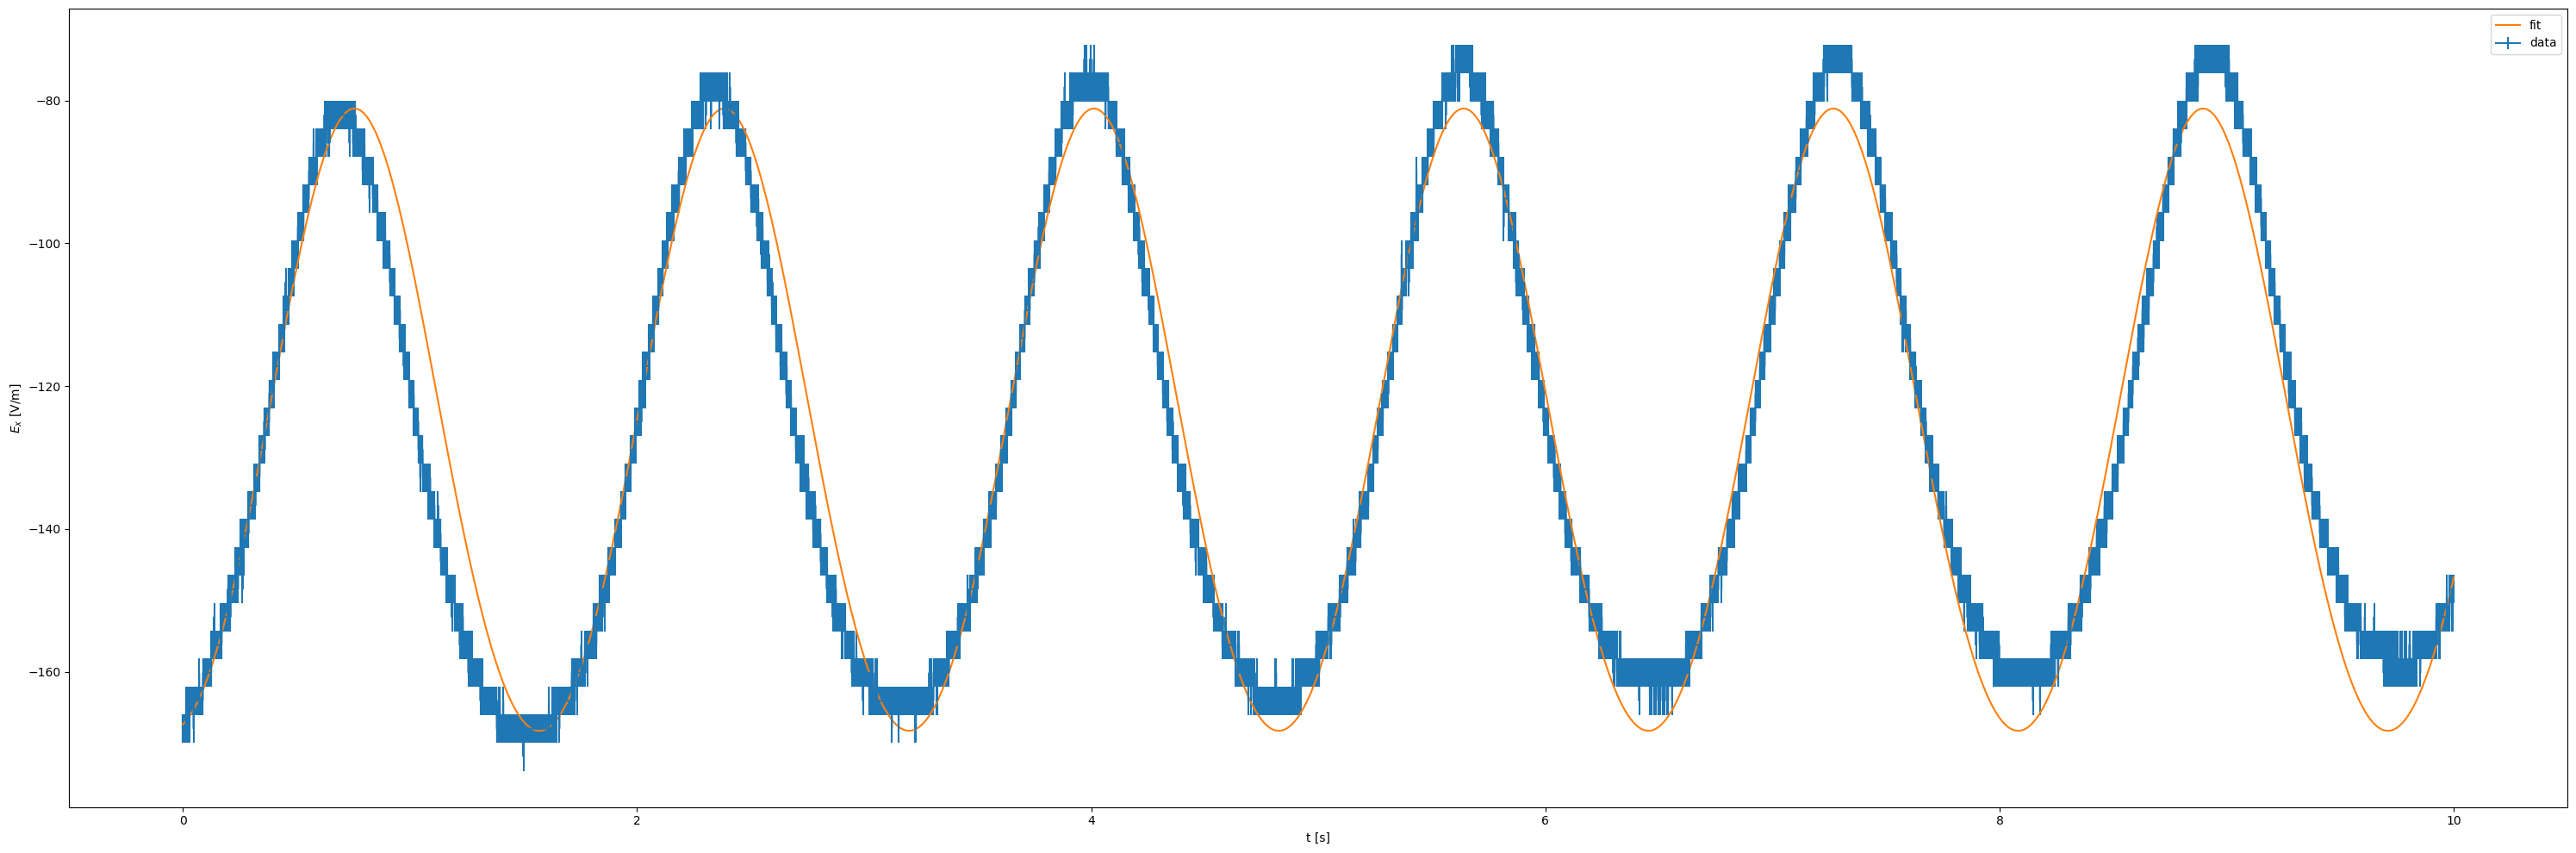

3.8553386833890952 omega_inval
C_0 by fft -626.8945312496526
2
[0.1, 0.32608695652173914, -490, 4, 4.725897920604916e-09]
beginvwd:  [0.1, 0.32608695652173914, -490, 4, 4.725897920604916e-09]
bounds:  [(-6.283185307179586, 6.283185307179586), (0, 2), (None, None), (2.891504012541821, 4.819173354236369), (1e-10, 0.01)]
[[2.1498529216613567, 2.1531401473168494], [0.08491574486666272, 0.08517926573184069], [-488.4724995099046, -488.66935872200173], [1.7501385138306023, 5.876333310148995], [3.654423359991008e-05, 3.655888495424982e-05]]
phi heeft als waarde: 2.1509 + 0.0022181 - 0.0010691 met 68% betrouwbaarheidsinterval: [2.1499, 2.1531] 
A_norm heeft als waarde: 0.085075 + 0.0001042 - 0.00015932 met 68% betrouwbaarheidsinterval: [0.084916, 0.085179] 
C_0 heeft als waarde: -488.64 + -0.027727 - -0.16913 met 68% betrouwbaarheidsinterval: [-488.47, -488.67] 
omega heeft als waarde: 3.8277 + 2.0486 - 2.0776 met 68% betrouwbaarheidsinterval: [1.7501, 5.8763] 
q_norm heeft als waarde: 3.6549e-

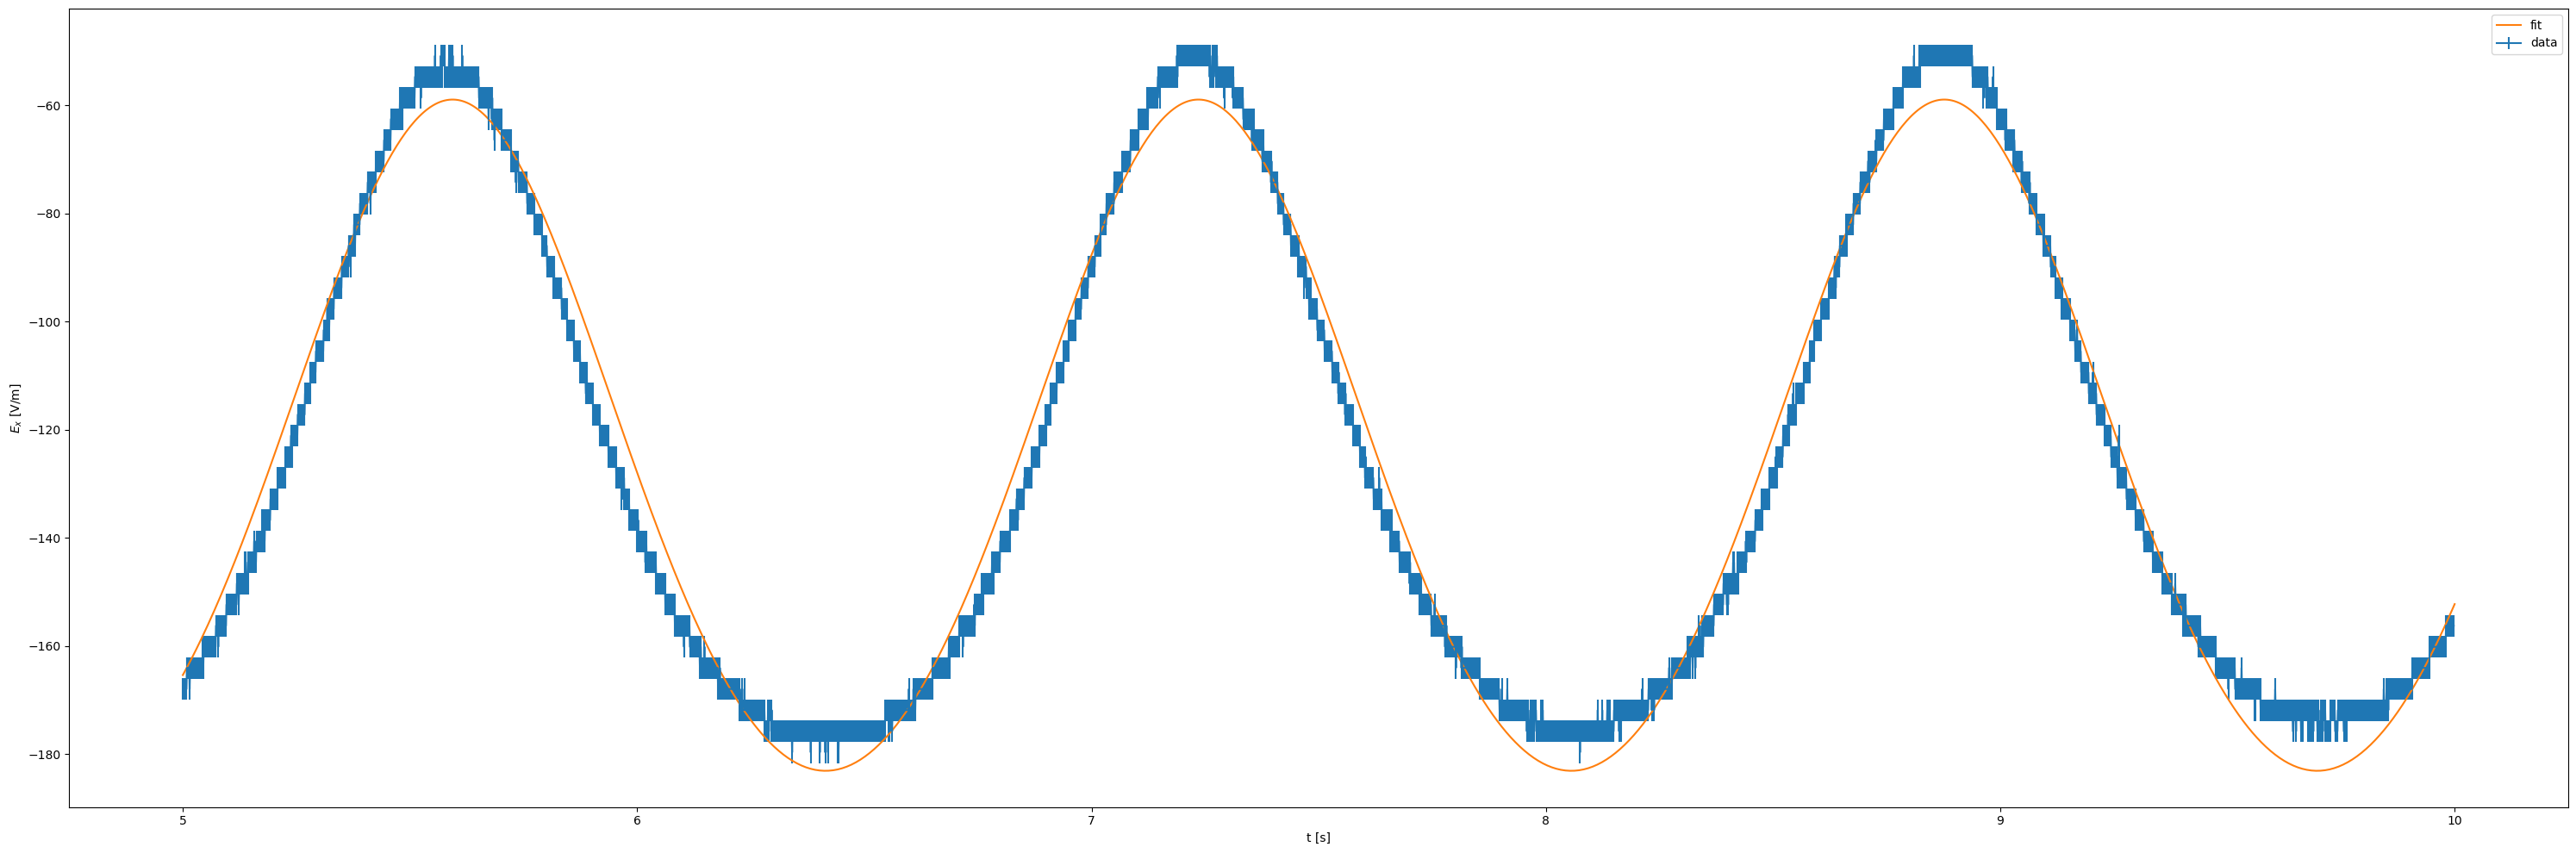

3.8553386833890952 omega_inval
C_0 by fft -1199.5390625
5
[-1.3, 0.32608695652173914, -300, 3.8553386833890952, 4.725897920604916e-09]
beginvwd:  [-1.3, 0.32608695652173914, -300, 3.8553386833890952, 4.725897920604916e-09]
bounds:  [(-6.283185307179586, 6.283185307179586), (0, 2), (None, None), (2.891504012541821, 4.819173354236369), (1e-10, 0.01)]
[[-1.2005846591680167, -1.204319835819177], [0.10650618751809547, 0.1069797452820339], [-289.2395909044488, -289.3402931449735], [1.8354168271038867, 7.69413473790542], [1.6869107597136103e-05, 1.6879730611516042e-05]]
phi heeft als waarde: -1.2025 + -0.0018247 - -0.0019105 met 68% betrouwbaarheidsinterval: [-1.2006, -1.2043] 
A_norm heeft als waarde: 0.1066 + 0.00037998 - 9.3575e-05 met 68% betrouwbaarheidsinterval: [0.10651, 0.10698] 
C_0 heeft als waarde: -289.28 + -0.06416 - -0.036542 met 68% betrouwbaarheidsinterval: [-289.24, -289.34] 
omega heeft als waarde: 3.812 + 3.8821 - 1.9766 met 68% betrouwbaarheidsinterval: [1.8354, 7.6941] 
q

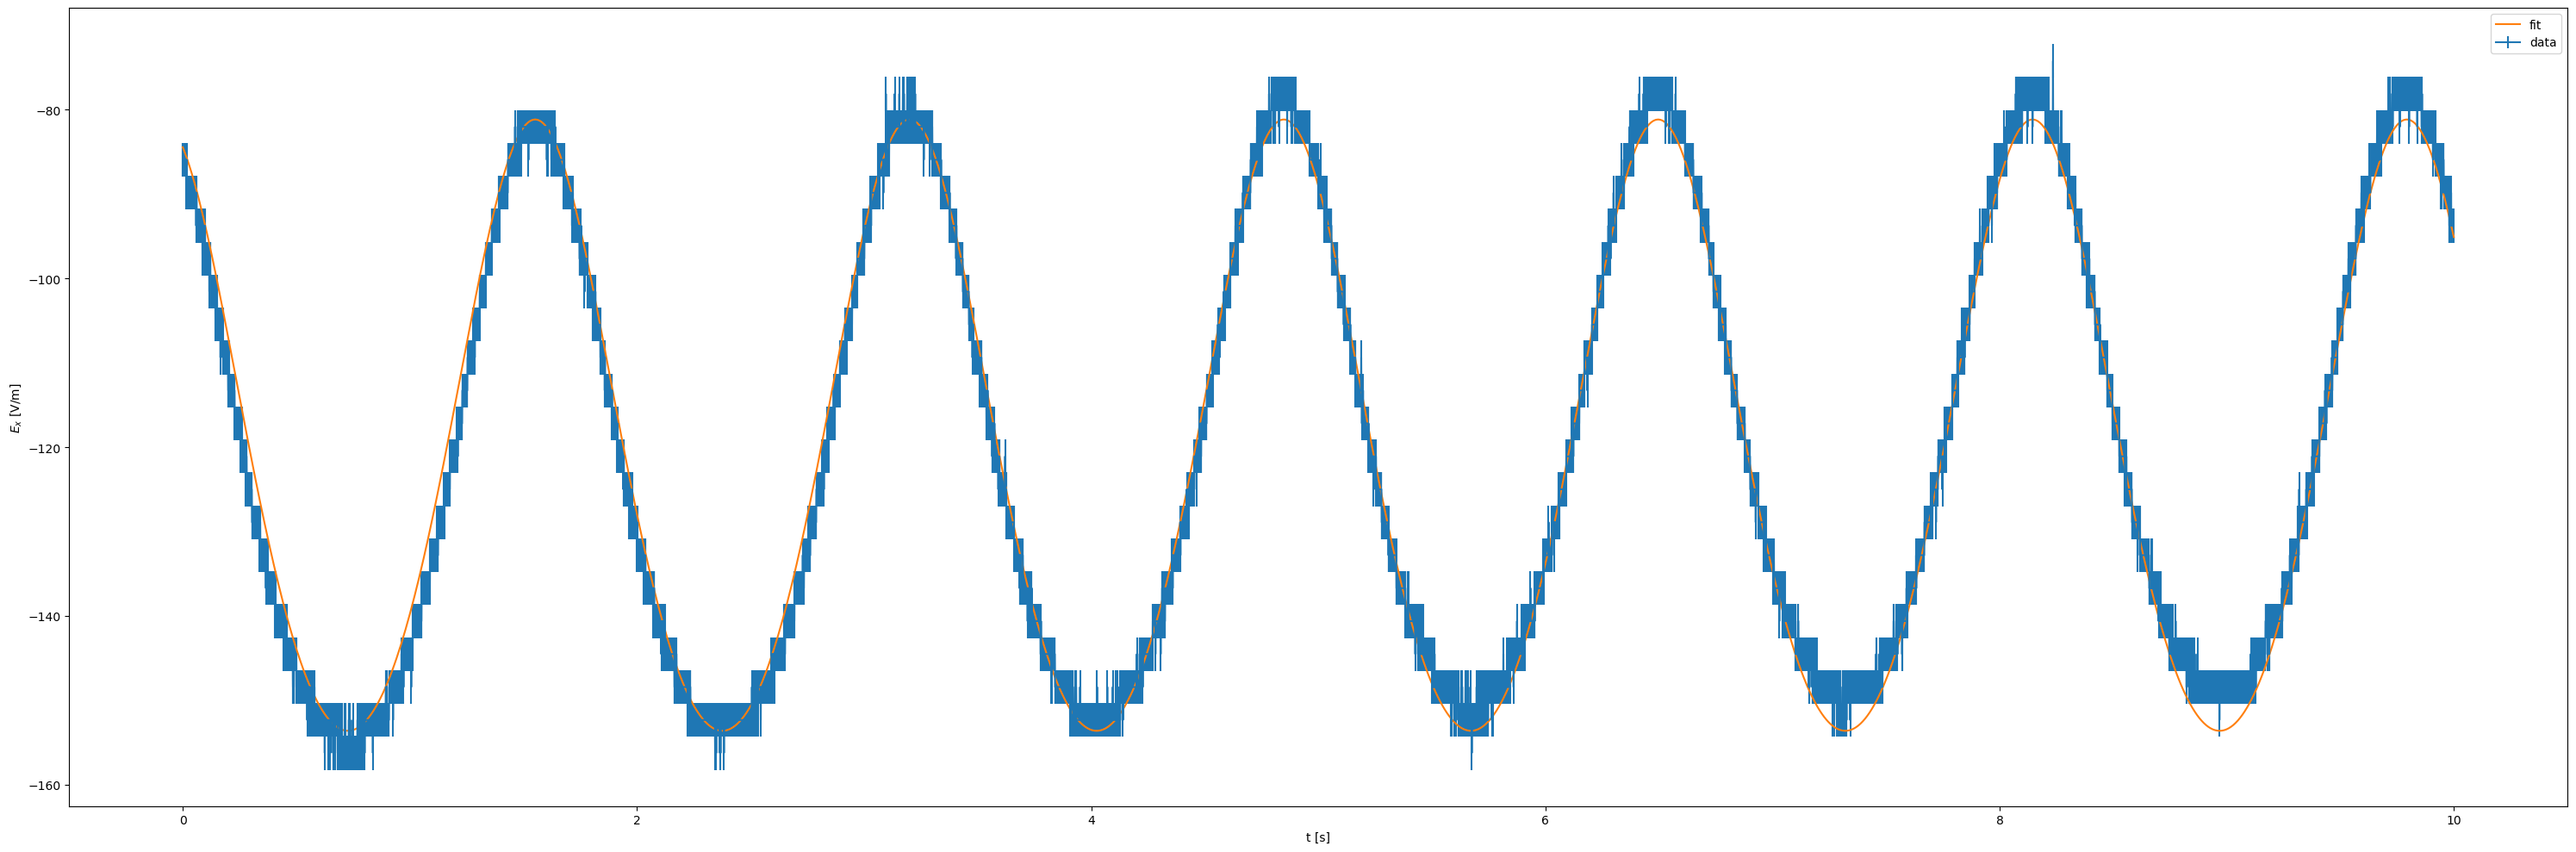

In [6]:
# parameters beginvoorwaarden: 'phi', 'A', 'C_0', 'omega', 'q'
#proef 3: OK
analyseer_data('Vrije proef/m3-1.txt', 0.57, 0.66, 1e-9, beginvoorwaarden = [.1, .15, -490, 4.028, 1e-9], minimizemethod = 'TNC')#, constbounds = (-520, -300))
analyseer_data('Vrije proef/m3-2.txt', 0.57, 0.66, 1e-9, beginvoorwaarden = [0.1, .15, -490, 4 , 1e-9], knipvanaf = 5, detailed_logs = False, minimizemethod='TNC')
analyseer_data('Vrije proef/m3-3.txt', 0.57, 0.66, 1e-9, minimizemethod='TNC')

4.50206564160523 omega_inval
C_0 by fft 1429.98046875
5
[0.1, 0.32608695652173914, -490, 4.028, 4.725897920604916e-09]
beginvwd:  [0.1, 0.32608695652173914, -490, 4.028, 4.725897920604916e-09]
bounds:  [(-6.283185307179586, 6.283185307179586), (0, 2), (None, None), (3.3765492312039225, 5.627582052006538), (1e-10, 0.01)]
[[1.3228057834489753, 1.3336862291152403], [-0.12635943726380325, -0.1284212452525096], [-360.934326356417, -361.5143597085987], [1.882185548644849, 7.674913332215539], [4.980019873605735e-05, 4.982912679842516e-05]]
phi heeft als waarde: 1.3228 + 0.010855 - 2.5802e-05 met 68% betrouwbaarheidsinterval: [1.3228, 1.3337] 
A_norm heeft als waarde: -0.12636 + -0.00206 - -1.8006e-06 met 68% betrouwbaarheidsinterval: [-0.12636, -0.12842] 
C_0 heeft als waarde: -360.94 + -0.57596 - -0.0040707 met 68% betrouwbaarheidsinterval: [-360.93, -361.51] 
omega heeft als waarde: 3.8203 + 3.8546 - 1.9381 met 68% betrouwbaarheidsinterval: [1.8822, 7.6749] 
q_norm heeft als waarde: 4.9828e

c:\Users\User\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:580: RuntimeWarning: Method BFGS cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
c:\Users\User\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
c:\Users\User\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


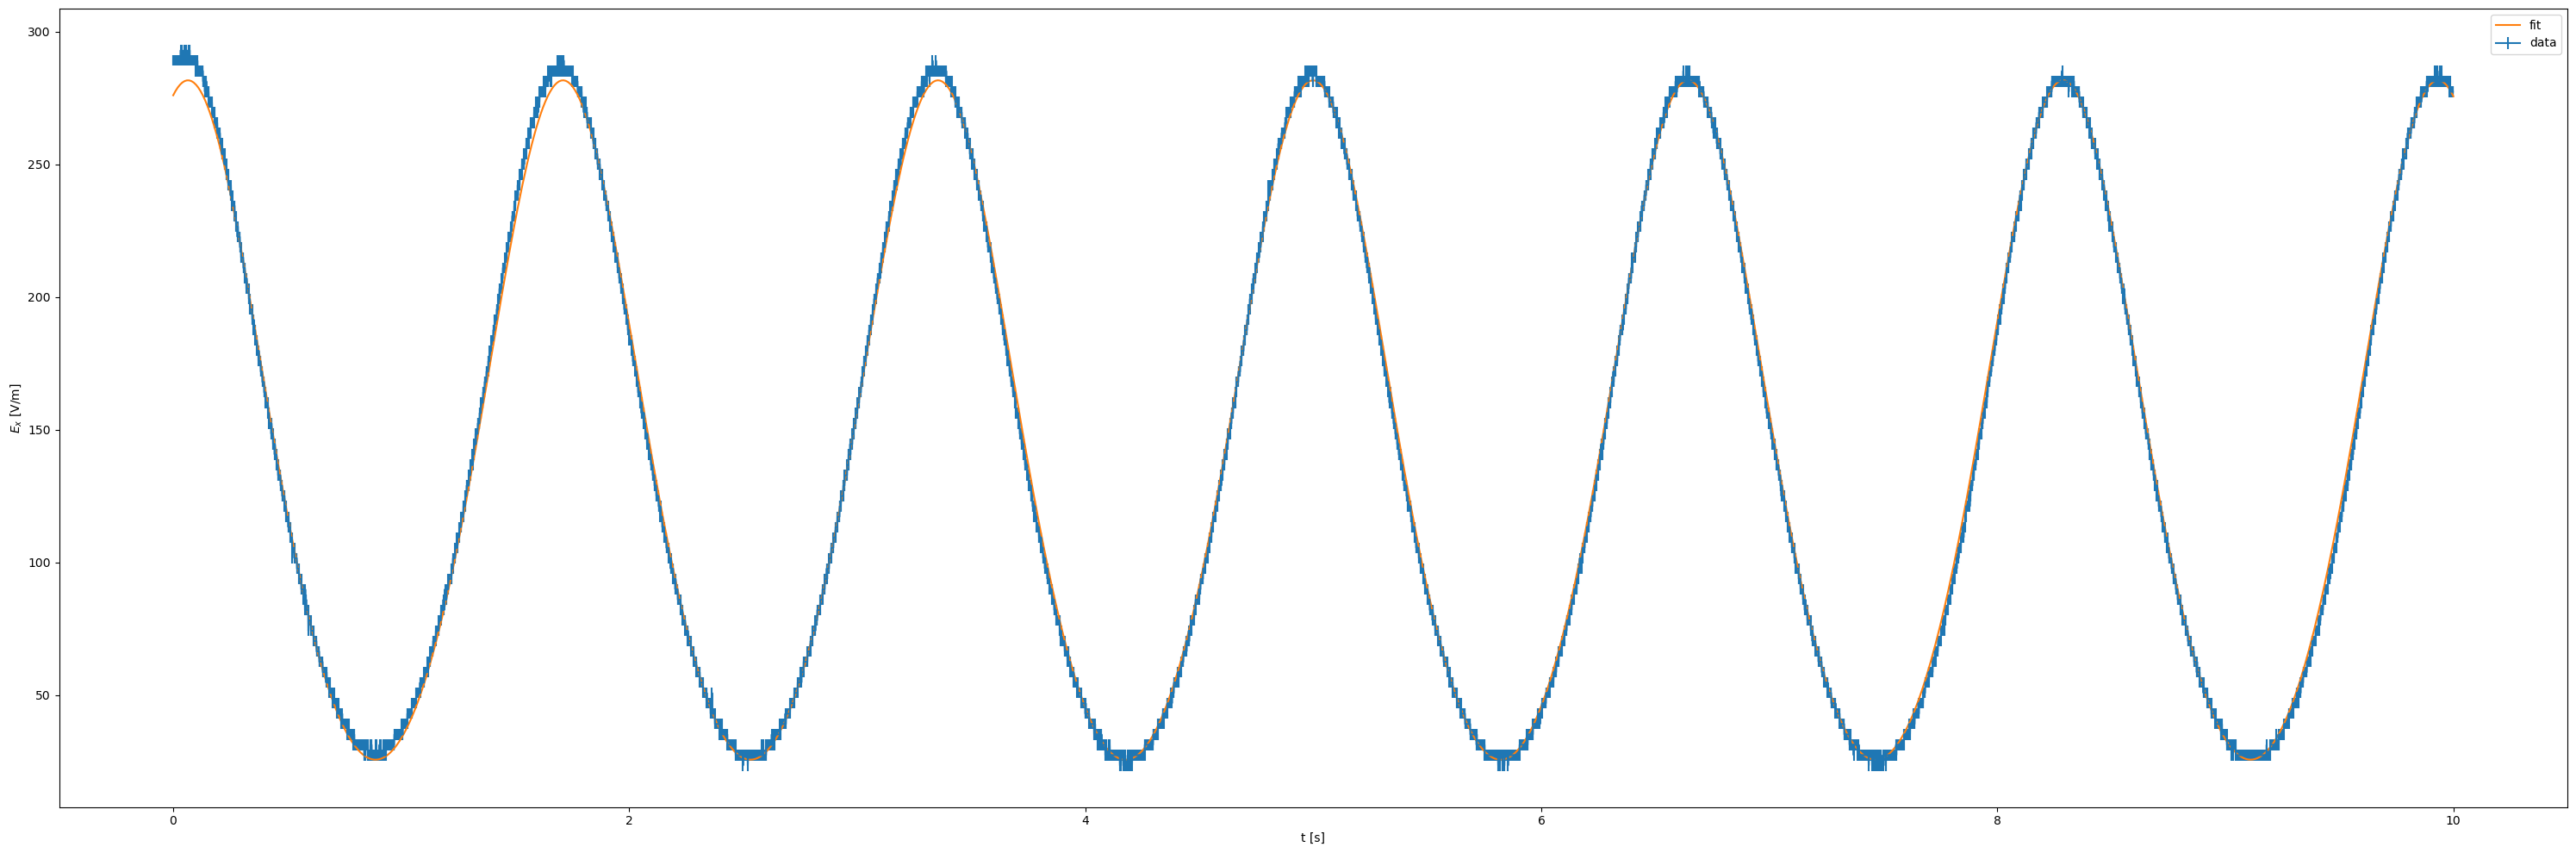

4.043513323831146 omega_inval
C_0 by fft 2793.3515625
9992
[0.1, 0.32608695652173914, -500, 4, 4.725897920604916e-09]
beginvwd:  [0.1, 0.32608695652173914, -500, 4, 4.725897920604916e-09]
bounds:  [(-6.283185307179586, 6.283185307179586), (0, 2), (None, None), (3.0326349928733594, 5.054391654788932), (1e-10, 0.01)]
[[0.27369137633690344, 0.2788474403944274], [0.07777198089171543, 0.07847737731487911], [-225.7341863507751, -225.97319798455388], [2.424959696943663, 7.8698809514889545], [5.0869306203554534e-05, 5.09038345743984e-05]]
phi heeft als waarde: 0.2787 + 0.00014536 - 0.0050107 met 68% betrouwbaarheidsinterval: [0.27369, 0.27885] 
A_norm heeft als waarde: 0.078471 + 6.1778e-06 - 0.00069922 met 68% betrouwbaarheidsinterval: [0.077772, 0.078477] 
C_0 heeft als waarde: -225.74 + -0.22876 - -0.010249 met 68% betrouwbaarheidsinterval: [-225.73, -225.97] 
omega heeft als waarde: 3.8148 + 4.055 - 1.3899 met 68% betrouwbaarheidsinterval: [2.425, 7.8699] 
q_norm heeft als waarde: 5.0903e-

c:\Users\User\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:580: RuntimeWarning: Method BFGS cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
c:\Users\User\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
c:\Users\User\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


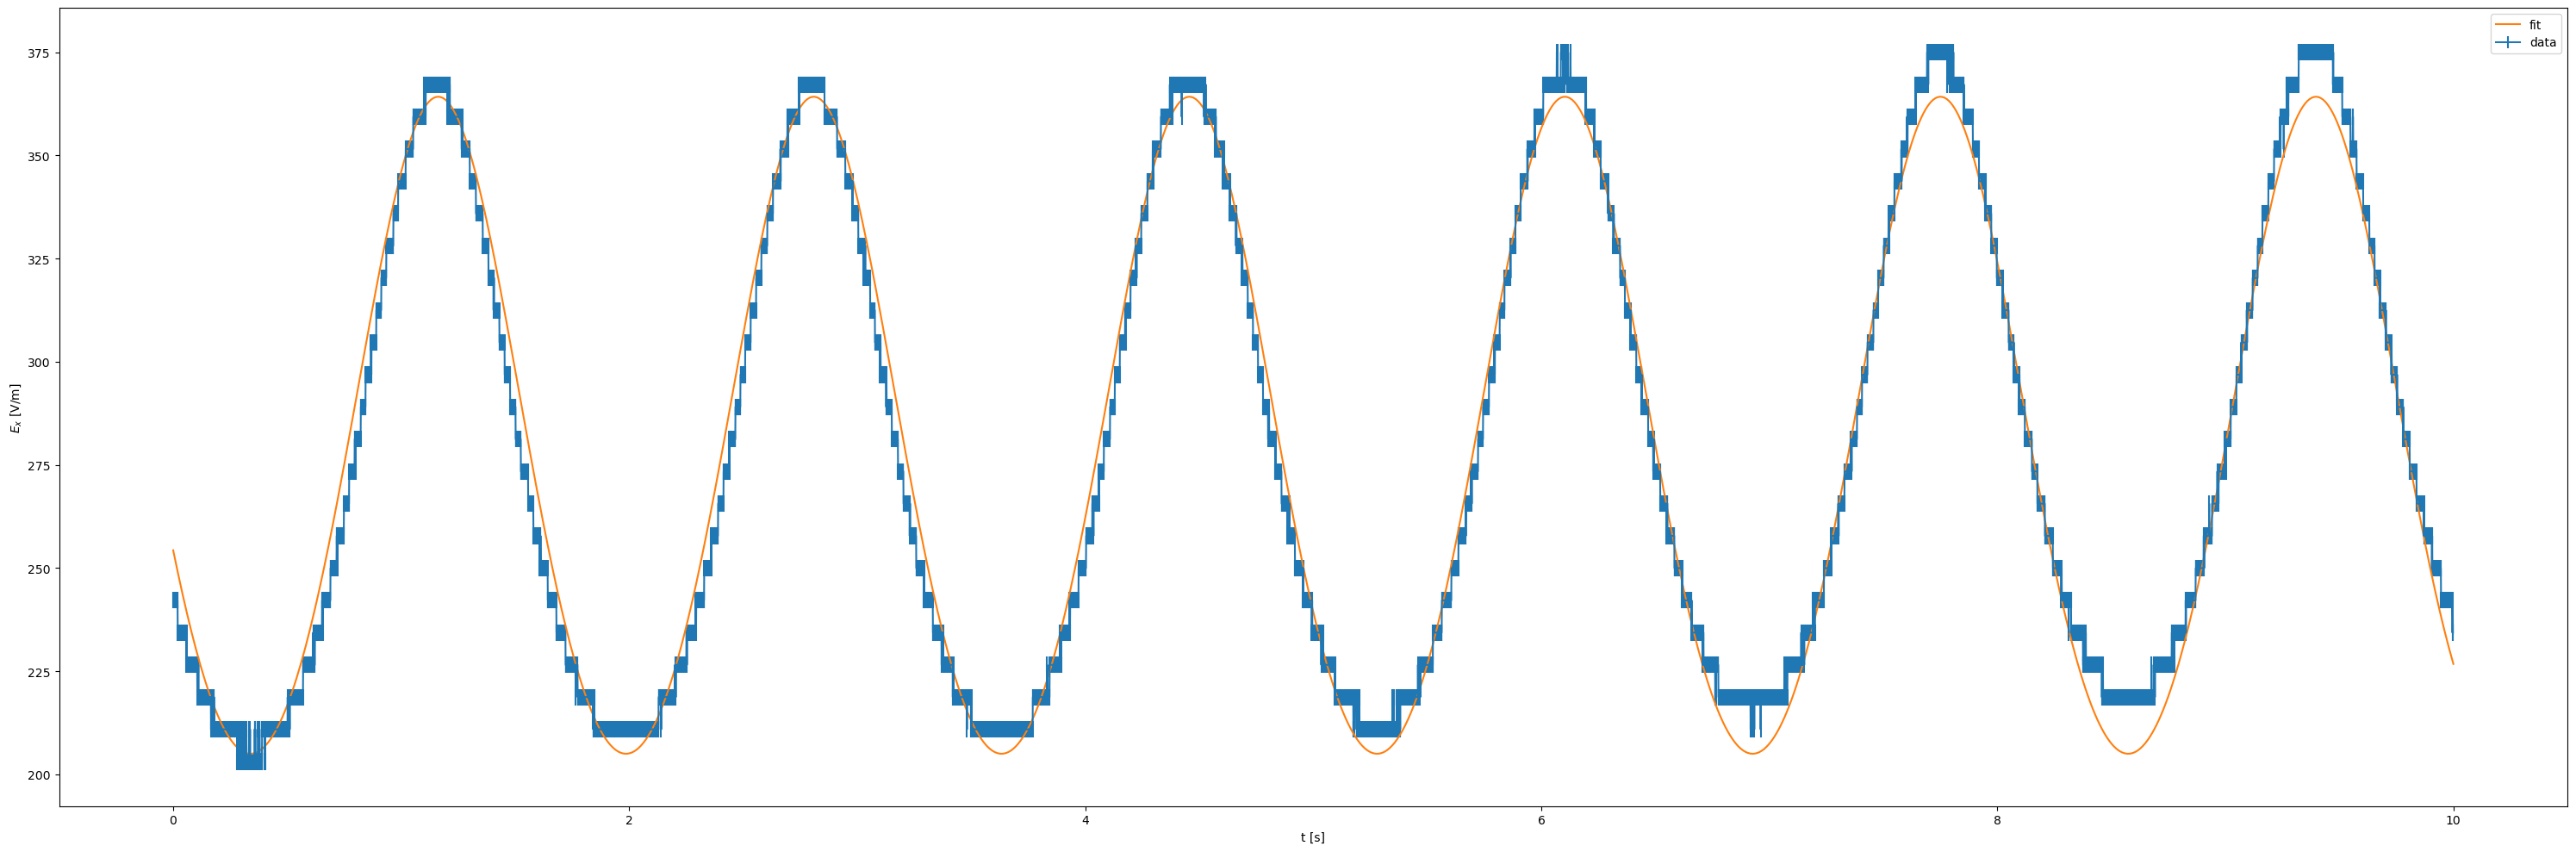

In [7]:
#proef 5: OKcch
analyseer_data('Vrije proef/m5-1.txt', 0.57, 0.484, 3e-9, beginvoorwaarden = [.1, .15, -490, 4.028, 1e-9], minimizemethod='BFGS')
analyseer_data('Vrije proef/m5-2.txt', 0.57, 0.60, 3e-9, beginvoorwaarden = [.1, .15, -500, 4, 1e-9], detailed_logs=False, minimizemethod = 'BFGS')

3.8553386833890952 omega_inval
C_0 by fft 2766.1718750009236
4
[0.3, 0.33333333333333326, 250, 4.2, 4.9382716049382706e-09]
beginvwd:  [0.3, 0.33333333333333326, 250, 4.2, 4.9382716049382706e-09]
bounds:  [(-6.283185307179586, 6.283185307179586), (0, 2), (None, None), (2.891504012541821, 4.819173354236369), (1e-10, 0.01)]
[[2.1184052975042618, 2.1195771600314877], [0.24510600690229425, 0.24535400126942364], [110.22789179322525, 110.3413266458912], [3.8079061845146454, 7.163499226975922], [2.4531096617037517e-05, 2.454906952547986e-05]]
phi heeft als waarde: 2.1189 + 0.00068854 - 0.00048332 met 68% betrouwbaarheidsinterval: [2.1184, 2.1196] 
A_norm heeft als waarde: 0.24518 + 0.00017548 - 7.2511e-05 met 68% betrouwbaarheidsinterval: [0.24511, 0.24535] 
C_0 heeft als waarde: 110.29 + 0.047194 - 0.06624 met 68% betrouwbaarheidsinterval: [110.23, 110.34] 
omega heeft als waarde: 3.8078 + 3.3557 - -0.00010743 met 68% betrouwbaarheidsinterval: [3.8079, 7.1635] 
q_norm heeft als waarde: 2.453

c:\Users\User\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:580: RuntimeWarning: Method BFGS cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
c:\Users\User\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


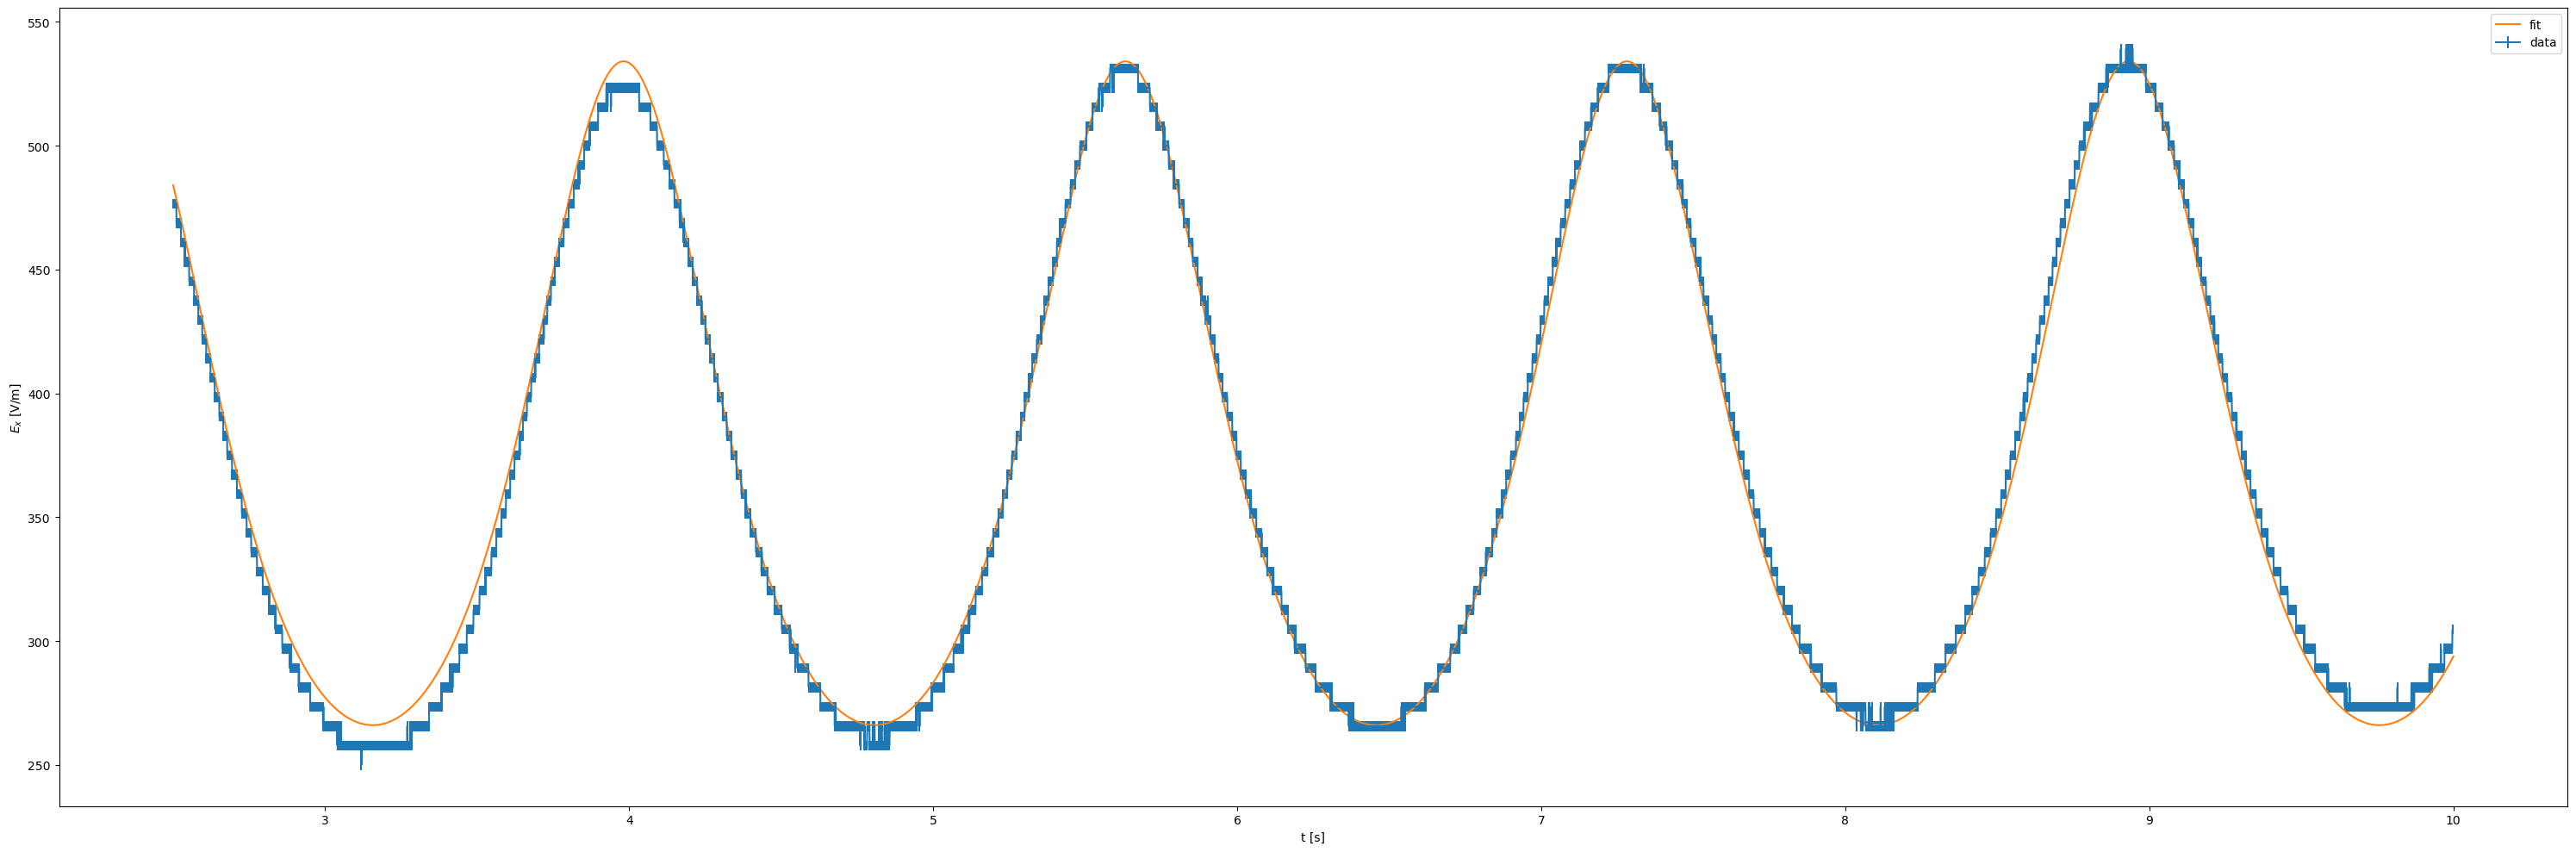

4.447271726176805 omega_inval
C_0 by fft 3299.445312499636
5
[0, 0.33333333333333326, -400, 4.5, 4.9382716049382706e-09]
beginvwd:  [0, 0.33333333333333326, -400, 4.5, 4.9382716049382706e-09]
bounds:  [(-6.283185307179586, 6.283185307179586), (0, 2), (None, None), (3.3354537946326035, 5.559089657721006), (1e-10, 0.01)]
[[0.9336349079855305, 0.9353542556891873], [-0.2853965444619354, -0.28703815524496723], [111.71497996466354, 111.97930853325364], [2.293601348103187, 8.902332937710655], [2.455700621274037e-05, 2.4610235258523894e-05]]
phi heeft als waarde: 0.93375 + 0.0016024 - 0.00011694 met 68% betrouwbaarheidsinterval: [0.93363, 0.93535] 
A_norm heeft als waarde: -0.2854 + -0.001637 - -4.6592e-06 met 68% betrouwbaarheidsinterval: [-0.2854, -0.28704] 
C_0 heeft als waarde: 111.73 + 0.25345 - 0.010883 met 68% betrouwbaarheidsinterval: [111.71, 111.98] 
omega heeft als waarde: 4.4768 + 4.4255 - 2.1832 met 68% betrouwbaarheidsinterval: [2.2936, 8.9023] 
q_norm heeft als waarde: 2.4557e-0

c:\Users\User\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:580: RuntimeWarning: Method BFGS cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
c:\Users\User\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
c:\Users\User\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


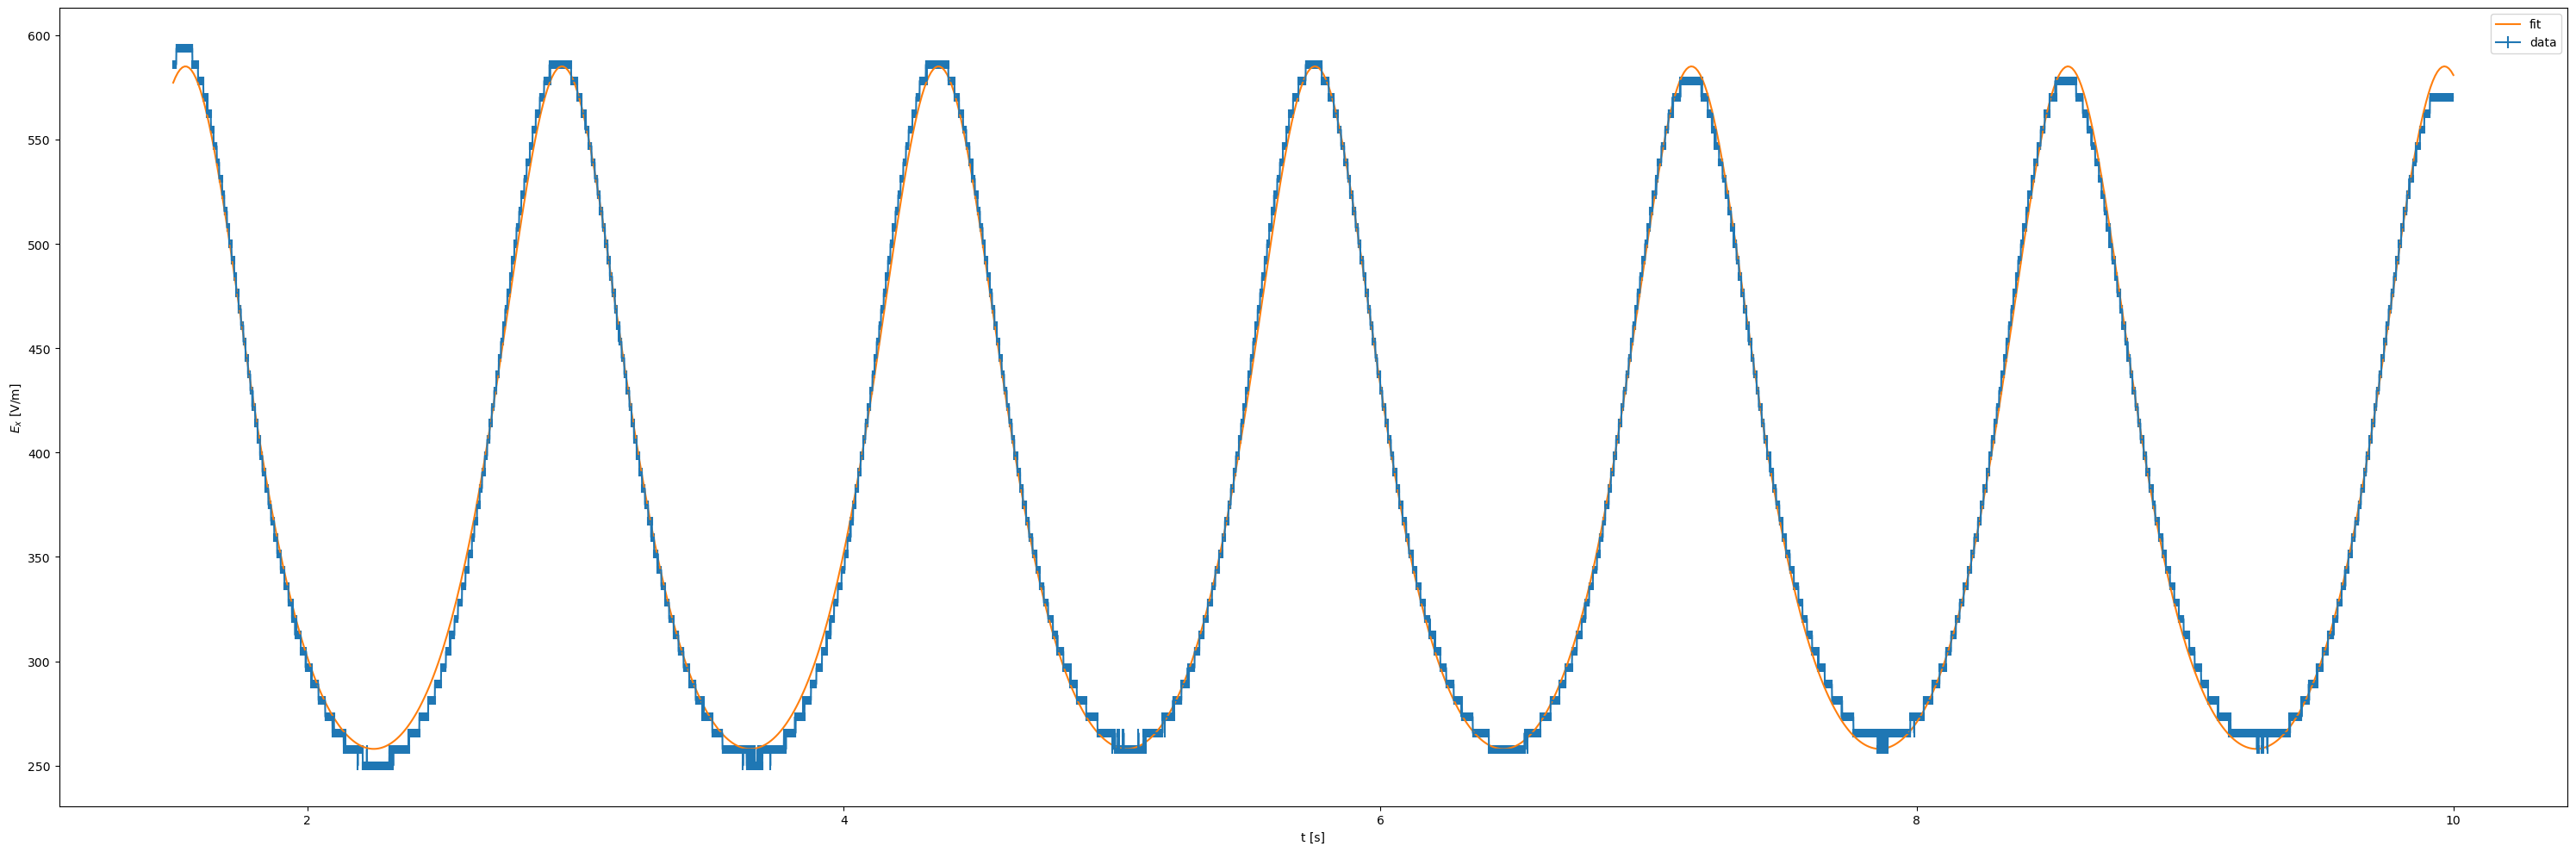

5.054391654788932 omega_inval
C_0 by fft 2275.3515625
5994
[0, 0.33333333333333326, -200, 5.5, 4.9382716049382706e-09]
beginvwd:  [0, 0.33333333333333326, -200, 5.5, 4.9382716049382706e-09]
bounds:  [(-6.283185307179586, 6.283185307179586), (0, 2), (None, None), (3.790793741091699, 6.3179895684861656), (1e-10, 0.01)]
[[-0.38708904884777395, -0.3883507720564849], [0.23425044901112932, 0.23637854266655184], [93.31452873622248, 93.57382827605672], [2.408230033043424, 5.0792362687451105], [2.696625325440695e-05, 2.7020580872300962e-05]]
phi heeft als waarde: -0.38784 + -0.00051132 - -0.0007504 met 68% betrouwbaarheidsinterval: [-0.38709, -0.38835] 
A_norm heeft als waarde: 0.23426 + 0.0021219 - 6.2285e-06 met 68% betrouwbaarheidsinterval: [0.23425, 0.23638] 
C_0 heeft als waarde: 93.331 + 0.24324 - 0.016063 met 68% betrouwbaarheidsinterval: [93.315, 93.574] 
omega heeft als waarde: 5.0793 + -7.8904e-05 - 2.6711 met 68% betrouwbaarheidsinterval: [2.4082, 5.0792] 
q_norm heeft als waarde: 2.

c:\Users\User\anaconda3\Lib\site-packages\scipy\optimize\_minimize.py:580: RuntimeWarning: Method BFGS cannot handle bounds.
  warn('Method %s cannot handle bounds.' % method,
c:\Users\User\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


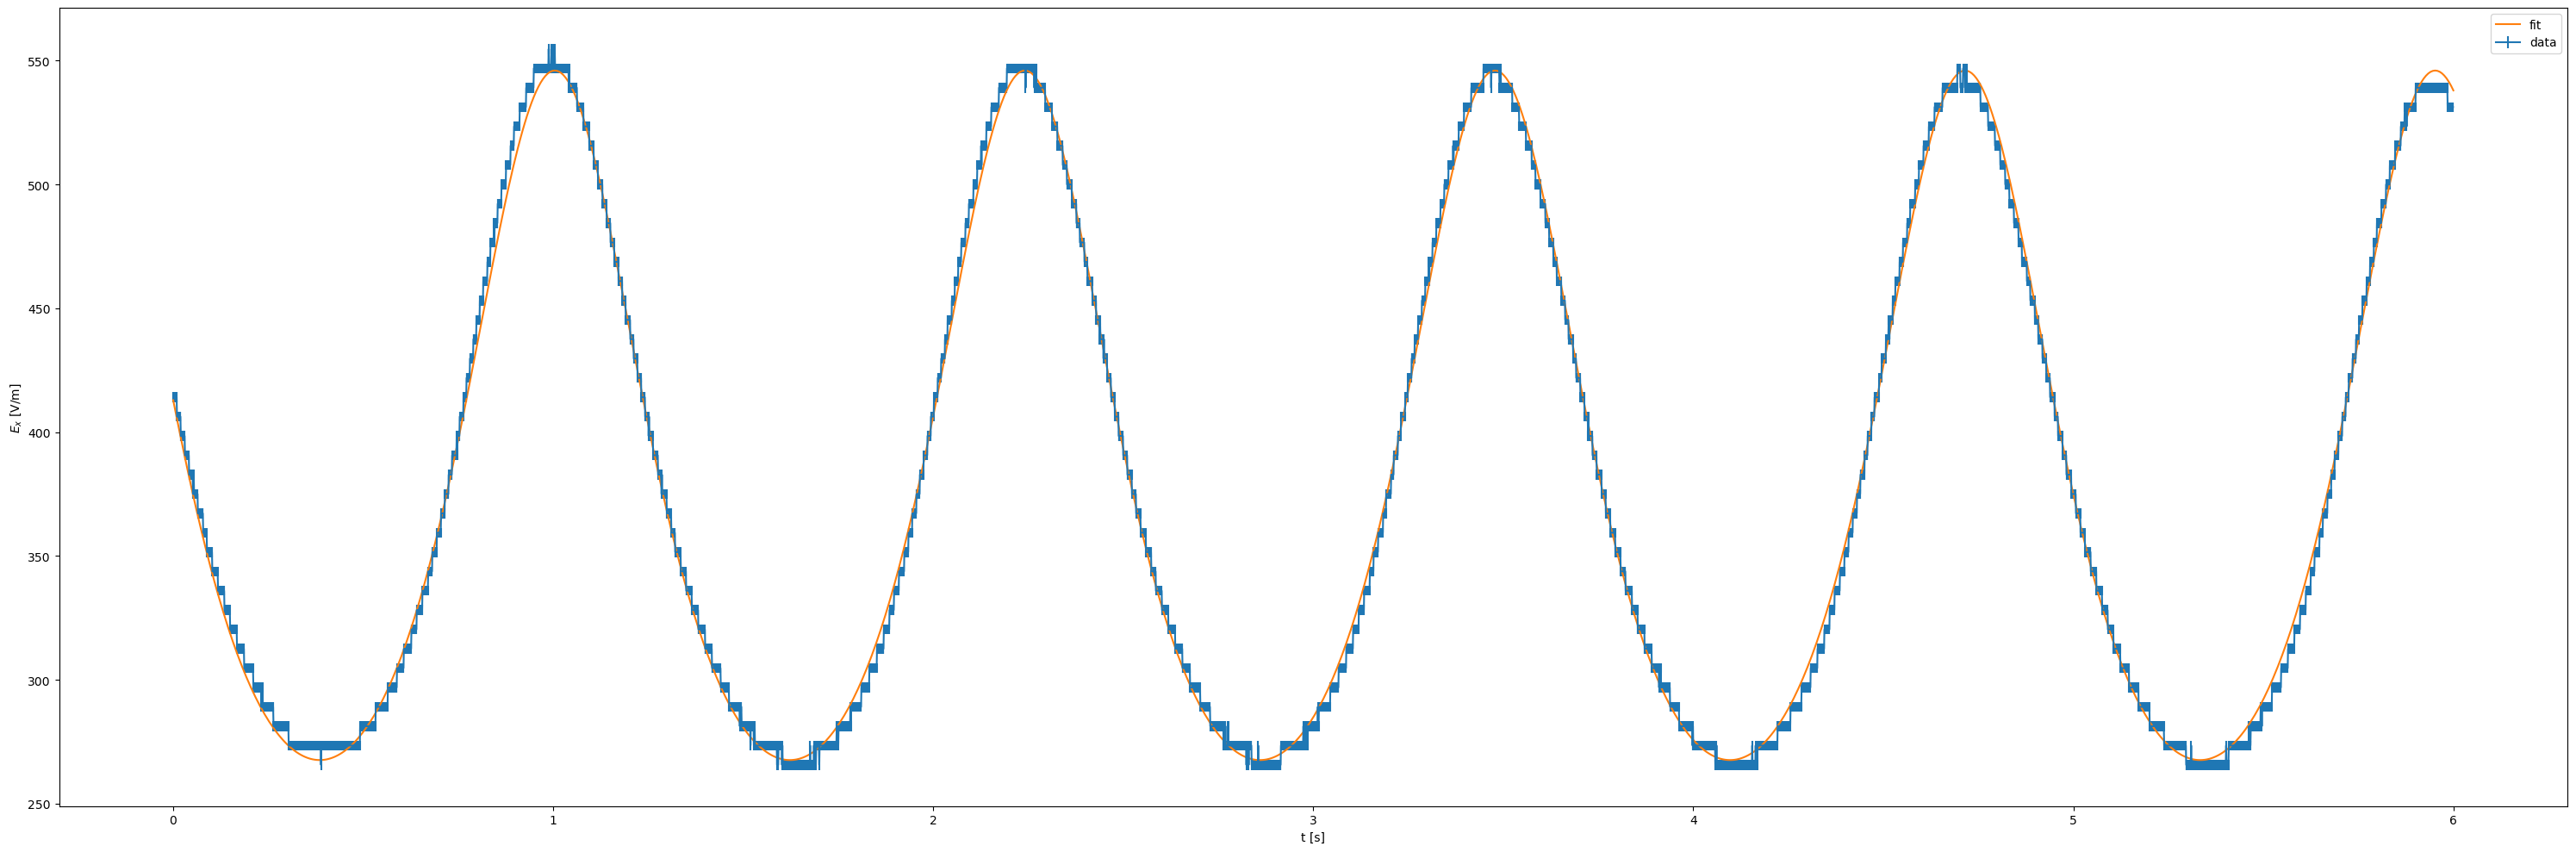

In [8]:
#proef 6: OK
analyseer_data('Vrije proef/m6-1.txt', 0.56, 0.66, 3e-9, knipvanaf = 2.5, beginvoorwaarden = [0.3, .15, 250, 4.2, 1e-9], detailed_logs=False, minimizemethod='BFGS') #iets vaag met de amplitude (windstoot ofzo idk) maar voor de rest ok
analyseer_data('Vrije proef/m6-2.txt', 0.56, 0.496, 3e-9, knipvanaf = 1.5, detailed_logs = False, beginvoorwaarden = [0, .15, -400, 4.5, 1e-9], minimizemethod='BFGS') #idem
analyseer_data('Vrije proef/m6-3.txt', 0.56, 0.384, 3e-9, beginvoorwaarden = [0, .15, -200, 5.5, 1e-9], kniptot = 6, detailed_logs=False, minimizemethod='BFGS')

In [9]:
print(fitparamdict)
nieuwdict = dict()
for key in fitparamdict.keys():
    nieuwdict[key] = [functies.datapunt_to_vector(fitparamdict[key][i]) for i in range(5)]
print('fitparamdict = ' + str(nieuwdict))

{'m1-1': [datapunt: phi = [-1.0591973775441228, 0.0020056171120131578, 'S'], datapunt: A_norm*x0 = [0.109518903942109, 0.0005375223111283924, 'Normaal'], datapunt: C_0 = [-522.2492143895824, 0.43019646674513723, 'S'], datapunt: omega = [3.810252048441806, 3.600000001125, 'S'], datapunt: q_norm*x0*x0 = [8.16392536381126e-09, 5.620789983718521e-11, 'Normaal']], 'm1-2': [datapunt: phi = [-0.056873116623286694, 0.002322154172315008, 'S'], datapunt: A_norm*x0 = [-0.09516181991784649, -0.0005231770731133914, 'Normaal'], datapunt: C_0 = [-489.29048205397726, 0.12961867149450346, 'S'], datapunt: omega = [3.8181917077959318, 1.800000230027763, 'S'], datapunt: q_norm*x0*x0 = [6.052521802285518e-09, 4.186708670941343e-11, 'Normaal']], 'm1-3': [datapunt: phi = [-3.191830760714013, 0.005302725714196426, 'S'], datapunt: A_norm*x0 = [0.053866449985915124, 0.0002800349743694894, 'Normaal'], datapunt: C_0 = [-603.4840623796842, 0.6700551917566194, 'S'], datapunt: omega = [3.8156393319791757, 1.80000001